## Condensation of Toluene/THF/Water Mixture

Toluene, THF (tetrahydrofuran) and water in a given ratio are distilled under vacuum from a reactor vessel via a primary & secondary condenser system. See below for general configuration.

### 1.0 Purpose:
Determine condensation efficiency of the condensers as function of the gas/vapour temperature reached on exit i.e. the approach to the glycol inlet temperature.

- Case 1: Heat input via reactor jacket causes boilup.
- Case 2: Evacuation from atmospheric pressure

The composition of the vapour evolved is a function of the VLE behaviour of the mixture as described below. Similarly, the condensation equilibrium also depends on the VLE.

In [1]:
from IPython.display import Image
Image(url="vacuumPumpSchematic.png",width=1200, height=700)

### 2.0 Pure component and mixture properties

The vapour pressure is the only variable required to model pure component condensation.  For mixtures, the NRTL model is used to describe the non-ideal behaviour in the liquid phase. 

Import necessary packages for the computations. The "phasepy" package is used for the VLE/VLLE calculations. The NRTL model is used to model liquid-phase non-ideality (binary interaction parameters taken from Aspen database)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from phasepy import  component, mixture, virialgamma,  preos
from phasepy.equilibrium import vlleb, vlle, lle, lle_init
from phasepy.equilibrium import bubblePy, bubbleTy, dewPx, dewTx, tpd_min, tpd_minimas
from phasepy.actmodels import nrtl
from scipy.optimize import fsolve

lw = 2

import pandas as pd

NRTL_params = {
    'toluene/THF'   : {'aij': -0.493,   'aji': 1.2217,  'bij': 348.114, 'bji': -622.977, 'cij': 0.3, 'cji': 0.3 },
    'toluene/water' : {'aij': -7.2357,  'aji': 3.9884,  'bij': 4292.44, 'bji': 996.703,  'cij': 0.2, 'cji': 0.2 },
    'THF/water'     : {'aij': 1.21416,  'aji': 4.76015, 'bij': 157.781, 'bji': -733.402, 'cij': 0.472553, 'cji':  0.472553 },
}
df = pd.DataFrame(NRTL_params)
print(df)
# display(df)


     toluene/THF  toluene/water   THF/water
aij      -0.4930        -7.2357    1.214160
aji       1.2217         3.9884    4.760150
bij     348.1140      4292.4400  157.781000
bji    -622.9770       996.7030 -733.402000
cij       0.3000         0.2000    0.472553
cji       0.3000         0.2000    0.472553


Define pure components, and calculate pure component properties:

In [54]:
toluene = component(name='toluene', Mw=92.14, Tc=647.13, Pc=220.55, Zc=0.229, Vc=55.948, 
                  w=0.344861, 
                  Ant=[4.14157/np.log10(np.e), 1377.578/np.log10(np.e), -50.773] )

THF = component(name='THF', Mw=84.93, Tc=510, Pc=61, Zc=0.277, Vc=193, 
                  w=0.268, 
                  Ant=[4.12118/np.log10(np.e), 1202.942/np.log10(np.e), -46.818])

water = component(name='water', Mw=18.02, Tc=647.13, Pc=220.55, Zc=0.229, Vc=55.948, 
                  w=0.344861, Ant=[11.64785144, 3797.41566067, -46.77830444],
                  GC={'H2O':1})

print('Toluene saturation pressure at 384.2K (111C):    {:0.4f}'.format( toluene.psat(T=111+273.16), 'bar') )
print('THF saturation pressure at 339.2K (66C):         {:0.4f}'.format( THF.psat(T=66+273.16), 'bar') )
print('Water saturation pressure at 373.2K (100C):      {:0.4f}'.format( water.psat(T=100+273.16), 'bar') )
print()

# Binary mixture parameters
# alpha = np.array([[0.0, NRTL_params['toluene/THF']['cij']],
#                   [NRTL_params['toluene/THF']['cji'], 0.0]])
# Aij0 = np.array([[0.0, NRTL_params['toluene/THF']['bij']],
#               [NRTL_params['toluene/THF']['bji'], 0.0]])
# Aij1 = np.array([[0.0, NRTL_params['toluene/THF']['aij']],
#                [NRTL_params['toluene/THF']['aji'], 0.0]])

azeotropes = {} # Placeholder for azeotropes, to be calculated below
azeotropeTemperatures = {} # Placeholder for azeotrope temperatures, to be calculated below


from phasepy.actmodels import nrtl
x = np.array([0.33, 0.33, 0.34])
T = 350.0

y0 = np.array([0.33, 0.33, 0.34])
x0 = np.array([0.33, 0.33, 0.34])
P0 = 1.0
T0 = 350.0
RG = 8.314 # J/mol.K

TBub = []
TDew = []
gamma1 = []
gamma2 = []
y1List = []
y2List = []
sigmaxigammai = []

from thermo.chemical import Chemical
comp1 = Chemical('toluene')
comp1.calculate(T=293, P=101325)
comp2 = Chemical('tetrahydrofuran')
comp3 = Chemical('water')
comp2.calculate(T=293, P=101325)
print("Toluene mass density (kg/m3):    {:0.1f}".format( comp1.rhol ) )
print("THF mass density (kg/m3):        {:0.1f}".format( comp2.rhol ) )
print("Water mass density (kg/m3):      {:0.1f}".format( comp3.rhol ) )

print("Toluene molar weight (gm/mol):           {:0.2f}".format( comp1.MW ) )
print("THF molar weight (gm/mol):               {:0.2f}".format( comp2.MW ) )
print("Water molar weight (gm/mol):             {:0.2f}".format( comp3.MW ) )

print("Toluene molar density density (mol/m3):  {:0.1f}".format( comp1.rholm ) )
print("THF molar density density (mol/m3):      {:0.1f}".format( comp2.rholm ) )
print("Water molar density density (mol/m3):    {:0.1f}".format( comp3.rholm ) )

Toluene saturation pressure at 384.2K (111C):    1.0221
THF saturation pressure at 339.2K (66C):         1.0147
Water saturation pressure at 373.2K (100C):      1.0130

Toluene mass density (kg/m3):    867.1
THF mass density (kg/m3):        885.5
Water mass density (kg/m3):      997.1
Toluene molar weight (gm/mol):           92.14
THF molar weight (gm/mol):               72.11
Water molar weight (gm/mol):             18.02
Toluene molar density density (mol/m3):  9411.2
THF molar density density (mol/m3):      12280.7
Water molar density density (mol/m3):    55345.5


### 3.0 Initial Conditions in vessel

In [55]:
# Initial vessel conditions
V_Total = 3100

P = 1.013 # bar
distillationPressure = {'toluene/THF/water': 0.5}   # barA
initialPressure = 1.013 # barA
print("Distillation pressure        {:0.2f} barA".format( distillationPressure['toluene/THF/water'] ))

massFractionInitial = {'toluene':  0.58,
                        'THF':      0.38,
                        'water':    0.04} 
print("Massfraction toluene:        {:0.3f}".format(massFractionInitial['toluene']) )
print("Massfraction THF:            {:0.3f}".format( massFractionInitial['THF']) )
print("Massfraction water:          {:0.3f}".format( massFractionInitial['water']) )
print("Sum of massfractions:        {:0.3f}".format( sum(massFractionInitial.values()) ) )
print()

moleFractionInitial = {'toluene':  massFractionInitial['toluene']/toluene.Mw/((massFractionInitial['toluene']/toluene.Mw + massFractionInitial['THF']/THF.Mw + massFractionInitial['water']/water.Mw)),
                        'THF':      massFractionInitial['THF']/THF.Mw/((massFractionInitial['toluene']/toluene.Mw + massFractionInitial['THF']/THF.Mw + massFractionInitial['water']/water.Mw)),
                        'water':    massFractionInitial['water']/water.Mw/((massFractionInitial['toluene']/toluene.Mw + massFractionInitial['THF']/THF.Mw + massFractionInitial['water']/water.Mw))}

print("Molefraction toluene:        {:0.3f}".format( moleFractionInitial['toluene']) )
print("Molefraction THF:            {:0.3f}".format( moleFractionInitial['THF']) )
print("Molefraction water:          {:0.3f}".format( moleFractionInitial['water']) )
print("Sum of molefractions:        {:0.3f}".format( sum(moleFractionInitial.values()) ) )
print()

V_Initial = 3100/1000 # m3
rho_Initial = massFractionInitial['toluene']*comp1.rhol + massFractionInitial['THF']*comp2.rhol + massFractionInitial['water']*comp3.rhol 
M_Initial = V_Initial*rho_Initial

print("Mass of toluene initially:   {:0.1f} kg".format( M_Initial*massFractionInitial['toluene'] ))
print("Mass of THF initially:       {:0.1f} kg".format( M_Initial*massFractionInitial['THF'] ))
print("Mass of Water initially:     {:0.1f} kg".format( M_Initial*massFractionInitial['water'] ))
print("Total initial volume:        {:0.1f} L".format( V_Initial*1000 ))
print("Total initial mass:          {:0.1f} kg".format( M_Initial ))

molesInitial = {'toluene':  M_Initial*massFractionInitial['toluene']/toluene.Mw,
                'THF':      M_Initial*massFractionInitial['THF']/THF.Mw,
                'water':    M_Initial*massFractionInitial['water']/water.Mw}

print("Moles of toluene initially:   {:0.1f} kmol".format( molesInitial['toluene'] ))
print("Moles of THF initially:       {:0.1f} kmol".format( molesInitial['THF'] ))
print("Moles of Water initially:     {:0.1f} kmol".format( molesInitial['water'] ))
print("Total initial moles:          {:0.1f} kmol".format( molesInitial['toluene'] + molesInitial['THF'] + molesInitial['water'] ))

Distillation pressure        0.50 barA
Massfraction toluene:        0.580
Massfraction THF:            0.380
Massfraction water:          0.040
Sum of massfractions:        1.000

Molefraction toluene:        0.485
Molefraction THF:            0.344
Molefraction water:          0.171
Sum of molefractions:        1.000

Mass of toluene initially:   1581.0 kg
Mass of THF initially:       1035.8 kg
Mass of Water initially:     109.0 kg
Total initial volume:        3100.0 L
Total initial mass:          2725.9 kg
Moles of toluene initially:   17.2 kmol
Moles of THF initially:       12.2 kmol
Moles of Water initially:     6.1 kmol
Total initial moles:          35.4 kmol


### 4.0 VLE / VLLE Predictions for binary and ternary mixture

Toluene/THF/water is a ternary (3-component) mixture. Three binary pairs can be identified: 

- Pair 1-2:  toluene/THF
- Pair 1-3:  toluene/water 
- Pair 2-3:  THF/water 

Toluene/water is highly non-ideal forming a hetero-azeotrope.

A Txxy diagram depicts the liquid phases, and the location of heterogeneous azeotrope. The NRTL model is used here to calculate the key elements of the diagram.

The NRTL model computes the Gibbs's excess energy as follows:

$$ g^E = \sum_{i=1}^c  x_i \frac{\sum_{j=1}^c \tau_{ji}G_{ji}x_j}{\sum_{l=1}^c G_{li}x_l}$$

Where, 
$$ \tau_{ji} = \frac{A_{ji}}{T}, \quad G_{ji} = \exp{(-\alpha_{ji}\tau_{ji})}, \quad 
\alpha_{ji} = \alpha_{ij} $$

Here $A_{ij}$ and $\alpha_{ij}$ are the interaction energy and aleatory factor between the component $i$ and $j$

In Phasepy, the NRTL's interaction energies are computed as: $A_{ij} = A_{ij, 0} + A_{ij, 1} T$.


#### 4.1 Binary Mixture 1-2: toluene/THF

In [56]:
x0 = np.array([0.5, 0.5])     # Guess values for VLLE molefraction (phase 1)
w0 = np.array([0.5, 0.5])     # Guess values for VLLE molefraction (phase 2)

# alpha = np.array([[0, alpha12, alpha13],
#                       [alpha21, 0, alpha23],
#                       [alpha31, alpha32, 0]])

# g = np.array([[0, g12, g13],
#                   [g21, 0, g23],
#                   [g31, g32, 0]])

# g1 = np.array([[0, gT12, gT13],
#                    [gT21, 0, gT23],
#                    [gT31, gT32, 0]])

# mix.NRTL(alpha, g, g1)

# Binary mixture parameters
alpha = np.array([[0.0, NRTL_params['toluene/THF']['cij']],
                  [NRTL_params['toluene/THF']['cji'], 0.0]])
Aij0 = np.array([[0.0, NRTL_params['toluene/THF']['bij']],
              [NRTL_params['toluene/THF']['bji'], 0.0]])
Aij1 = np.array([[0.0, NRTL_params['toluene/THF']['aij']],
               [NRTL_params['toluene/THF']['aji'], 0.0]])

mix = mixture(toluene,THF)
mix.NRTL(alpha, Aij0, Aij1)
eos = virialgamma(mix, virialmodel='ideal_gas', actmodel='nrtl')  # no virial model, therefore 'ideal gas'

xInit= [0.5,0.5]

Z = np.array(xInit)             # Overall liquid molefraction
y0 = (x0 + w0)/2                # Guess value for vapour molefraction
# VLLE = vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True)
VLLE = vlleb(x0, w0, y0, T0, distillationPressure['toluene/THF/water'], 'P', eos, full_output=True)
print(VLLE)

TLiq=VLLE.T #[3]
xL=VLLE.X
# xL2=VLLE.X[1]
yLLE=VLLE.Y
print('Phase 1 molefraction: ', np.round(xL,3))
# print('Phase 2 molefraction: ', np.round(xL2,3))
print('Vapour molefraction:  ', np.round(yLLE,3))
print('Liquid temperature {:0.3f}'.format( TLiq[0]-273.16) )

      T: array([343.91400047])
      P: 0.5
  error: 3.95347570234579e-13
   nfev: 30
      X: array([0.71996701, 0.28003299])
     vx: None
 statex: 'Liquid'
      W: array([0.71996701, 0.28003299])
     vw: None
 statew: 'Liquid'
      Y: array([0.39237234, 0.60762766])
     vy: None
 statey: 'Vapor'
Phase 1 molefraction:  [0.72 0.28]
Vapour molefraction:   [0.392 0.608]
Liquid temperature 70.754


The Txy digram can be constructed using a series of bubble-point and dew-point calculations.

In [57]:
x1 = np.linspace(1,0,51).tolist()

TBub = []
TDew = []
yList = []

x2  = [1-x for x in x1]
P = distillationPressure['toluene/THF/water']
for xFrac in x2:
    x = np.array([1-xFrac, xFrac])
    y = x
    Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    TBub.append( Tbubble-273.16 )
    Tdew = dewTx(x0, T0, y, P, eos, full_output=True).T
    TDew.append( Tdew-273.16 )
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * toluene.psat(T=Tbubble)/P
    y2 = 1-y1
    yList.append(y2)

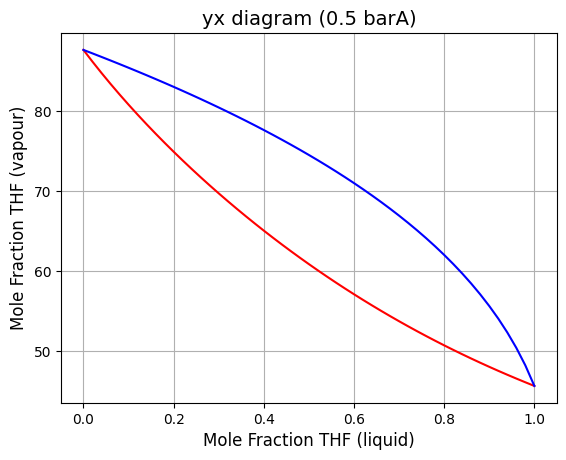

In [58]:
from plotFunctions import plotTxy
plotTxy(plt,x2, TDew,TBub,['toluene', 'THF'], yLLE,xInit, distillationPressure['toluene/THF/water'])

#### 4.2 Binary Mixture 1-3: toluene/water

To calculate the liquid-liquid phase boundaries, firstly calculate minimum values of the tangent-plane function:

In [59]:
# Binary mixture parameters
alpha = np.array([[0.0, NRTL_params['toluene/water']['cij']],
                  [NRTL_params['toluene/water']['cji'], 0.0]])
Aij0 = np.array([[0.0, NRTL_params['toluene/water']['bij']],
              [NRTL_params['toluene/water']['bji'], 0.0]])
Aij1 = np.array([[0.0, NRTL_params['toluene/water']['aij']],
               [NRTL_params['toluene/water']['aji'], 0.0]])

mix = mixture(toluene,water)
mix.NRTL(alpha, Aij0, Aij1)
eos = virialgamma(mix, virialmodel='ideal_gas', actmodel='nrtl')  # no virial model, therefore 'ideal gas'


T = 320.0
P = distillationPressure['toluene/THF/water']
z = np.array([xInit[0], xInit[1]])
w = np.array([0.01, 0.99])
print("Liquid molar fractions and TPD value: ", tpd_min(w, z, T, P, eos, stateW='L', stateZ='L'))
print("Vapor molar fractions and TPD value:" , tpd_min(w, z, T, P, eos, stateW='V', stateZ='L'))
print()
print()

nmin = 2
print("TPD liquid minima: ", tpd_minimas(nmin, z, T, P, eos, stateW='L', stateZ='L'))
print("TPD vapor minima: ", tpd_minimas(nmin, z, T, P, eos, stateW='V', stateZ='L'))


Liquid molar fractions and TPD value:  (array([1.27053157e-04, 9.99872947e-01]), -1.0821831058025118)
Vapor molar fractions and TPD value: (array([0.48143925, 0.51856075]), 0.1541618822977069)


TPD liquid minima:  ((array([9.99589172e-01, 4.10828080e-04]), array([1.27031409e-04, 9.99872969e-01])), array([-0.92348328, -1.08218311]))
TPD vapor minima:  ((array([0.48143953, 0.51856047]), array([0.48143953, 0.51856047])), array([0.15416188, 0.15416188]))


In [60]:
T = 310.0                       # Guess temperature for VLLE calculation
x0 = np.array([0.01, 0.99])     # Guess values for VLLE molefraction (phase 1)
w0 = np.array([0.99, 0.01])     # Guess values for VLLE molefraction (phase 2)
Z = np.array(xInit)             # Overall liquid molefraction
y0 = (x0 + w0)/2                # Guess value for vapour molefraction
VLLE = vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True)

TLiq=VLLE.T #[3]
xL1=VLLE.X[0]
xL2=VLLE.X[1]
yLLE=VLLE.X[2]
# print('Phase 1 molefraction: {:0.1f} kg'.format( xL1))
print("Phase 1 molefraction: " + ", ".join("%.6f" % f for f in xL1) )
# print('Phase 2 molefraction: ', np.round(xL2,3))
print("Phase 2 molefraction: " + ", ".join("%.6f" % f for f in xL2) )
# print('Vapour molefraction:  ', np.round(yLLE,3))
print("Vapour molefraction:  " + ", ".join("%.6f" % f for f in yLLE) )
print('Liquid temperature:   {:0.1f}'.format( TLiq-273.16) )


Phase 1 molefraction: 0.000159, 0.999841
Phase 2 molefraction: 0.999187, 0.000813
Vapour molefraction:  0.468688, 0.531312
Liquid temperature:   66.3


c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\hazt.py:258: UserWarning: Global mixture is a binary mixture, updating temperature
  warn('Global mixture is a binary mixture, updating temperature')


The Txy digram can be constructed using a series of bubble-point and dew-point calculations.

In [61]:
x1 = np.linspace(1,0,51).tolist()

TBub = []
TDew = []
yList = []

x2  = [1-x for x in x1]
P = distillationPressure['toluene/THF/water']
for xFrac in x2:
    x = np.array([1-xFrac, xFrac])
    y = x
    Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    TBub.append( Tbubble-273.16 )
    Tdew = dewTx(x0, T0, y, P, eos, full_output=True).T
    TDew.append( Tdew-273.16 )
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * toluene.psat(T=Tbubble)/P
    y2 = 1-y1
    yList.append(y2)

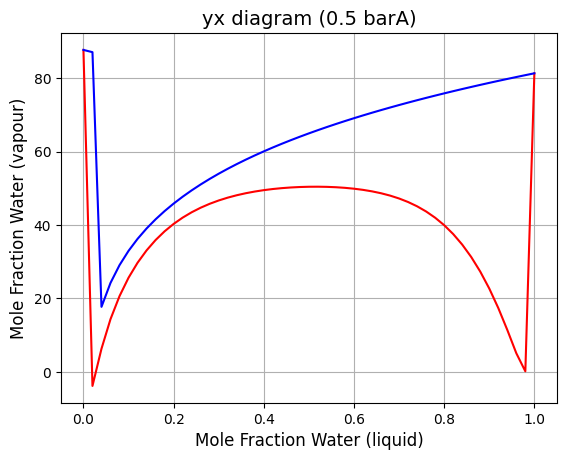

In [62]:
from plotFunctions import plotTxy
plotTxy(plt,x2, TDew,TBub,['toluene', 'Water'], yLLE,xInit,distillationPressure['toluene/THF/water'])

In [63]:
def calcBinaryAzeotrope(x):

    Tbubble = bubbleTy(np.array([0.5, 0.5]), T0, np.array(x), P, eos, full_output=True).T

    gam1 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[0] )
    gam2 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[1] )
    y1 = x[0] * gam1 * toluene.psat(Tbubble)/P
    y2 = x[1] * gam2 * water.psat(Tbubble)/P
    f = [  y1 - x[0], y2 - x[1]]
    return f

x = fsolve(calcBinaryAzeotrope, [.9, .1])

Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T

azeotropes['toluene/water'] = yLLE
azeotropeTemperatures['toluene/water'] = TLiq


#### 4.3 Binary Mixture 2-3: THF/water

To calculate the liquid-liquid phase boundaries, firstly calculate minimum values of the tangent-plane function:

In [64]:
# Binary mixture parameters
alpha = np.array([[0.0, NRTL_params['THF/water']['cij']],
                  [NRTL_params['THF/water']['cji'], 0.0]])
Aij0 = np.array([[0.0, NRTL_params['THF/water']['bij']],
              [NRTL_params['THF/water']['bji'], 0.0]])
Aij1 = np.array([[0.0, NRTL_params['THF/water']['aij']],
               [NRTL_params['THF/water']['aji'], 0.0]])

mix = mixture(THF,water)
mix.NRTL(alpha, Aij0, Aij1)
eos = virialgamma(mix, virialmodel='ideal_gas', actmodel='nrtl')  # no virial model, therefore 'ideal gas'

# nmin = 2
print("TPD liquid minima: ", tpd_minimas(nmin, z, T, P, eos, stateW='L', stateZ='L'))
print("TPD vapor minima: ", tpd_minimas(nmin, z, T, P, eos, stateW='V', stateZ='L'))
print()
P = distillationPressure['toluene/THF/water'] #1.013 # bar
T = 273.2+63.5                       # Guess temperature for VLLE calculation
x0 = np.array([0.3, 0.7])     # Guess values for VLLE molefraction (phase 1)
w0 = np.array([0.1, 0.9])     # Guess values for VLLE molefraction (phase 2)
Z = np.array([0.2,0.8])       # Overall liquid molefraction
y0 = np.array([0.82,0.18])    # Guess value for vapour molefraction
VLLE = vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True)
print(VLLE)
TLiq=VLLE.T 
xL1=VLLE.X[0]
xL2=VLLE.X[1]
yLLE=VLLE.X[2]

print("Phase 1 molefraction: " + ", ".join("%.6f" % f for f in xL1) )

print("Phase 2 molefraction: " + ", ".join("%.6f" % f for f in xL2) )

print("Vapour molefraction:  " + ", ".join("%.6f" % f for f in yLLE) )
print('Liquid temperature:   {:0.3f}'.format( TLiq-273.16) )

# azeotropes['THF/water'] = yLLE

print(azeotropes)


TPD liquid minima:  ((array([0.49997911, 0.50002089]), array([0.49997911, 0.50002089])), array([1.318059e-10, 1.318059e-10]))
TPD vapor minima:  ((array([0.8387346, 0.1612654]), array([0.8387346, 0.1612654])), array([0.29525687, 0.29525687]))

      T: 319.3368388915602
      P: 0.5
      X: array([[0.23020511, 0.76979489],
       [0.23020511, 0.76979489],
       [0.80700762, 0.19299238]])
      v: [None, None, None]
 states: ['L', 'L', 'V']
Phase 1 molefraction: 0.230205, 0.769795
Phase 2 molefraction: 0.230205, 0.769795
Vapour molefraction:  0.807008, 0.192992
Liquid temperature:   46.177
{'toluene/water': array([0.46868775, 0.53131225])}


Calculate the binary azeotrope composition by equating finding the compositon at which 

$$
y_{THF} = x_{THF}
$$
and 
$$y_{H2O} = x_{H2O}$$
where

$$
y_{THF} = \frac{x_{THF} \gamma_{THF}  p_{THF}^S(T)}{P}
$$
$$
y_{H2O} = \frac{x_{H2O} \gamma_{H2O}  p_{H2O}^S(T)}{P}
$$

In [65]:
def calcBinaryAzeotrope(x):

    Tbubble = bubbleTy(np.array([0.84, 0.16]), T0, np.array(x), P, eos, full_output=True).T

    gam1 = np.exp( nrtl(x,Tbubble,alpha, Aij0, Aij1)[0] )
    gam2 = np.exp( nrtl(x,Tbubble,alpha, Aij0, Aij1)[1] )
    y1 = x[0] * gam1 * THF.psat(Tbubble)/P
    y2 = x[1] * gam2 * water.psat(Tbubble)/P
    f = [  y1 - x[0], y2 - x[1]]
    return f

P = distillationPressure['toluene/THF/water'] #1.013 # bar
x = fsolve(calcBinaryAzeotrope, [.8, .2])
azeotropes['THF/water'] = x

Tbubble = bubbleTy([0.1, 0.1], T0, x, P, eos, full_output=True).T
azeotropeTemperatures['toluene/water'] = Tbubble

print(azeotropes)


{'toluene/water': array([0.46868775, 0.53131225]), 'THF/water': array([0.87468199, 0.12522737])}


The Txy digram can be constructed using a series of bubble-point and dew-point calculations.

In [66]:
x1 = np.linspace(1,0,51).tolist()

TBub = []
TDew = []
yList = []

x2  = [1-x for x in x1]
P = distillationPressure['toluene/THF/water'] #1.013 # bar
for xFrac in x2:
    x = np.array([1-xFrac, xFrac])
    y = x
    Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    TBub.append( Tbubble-273.16 )
    Tdew = dewTx(x0, T0, y, P, eos, full_output=True).T
    TDew.append( Tdew-273.16 )
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * THF.psat(T=Tbubble)/P
    y2 = 1-y1
    yList.append(y2)

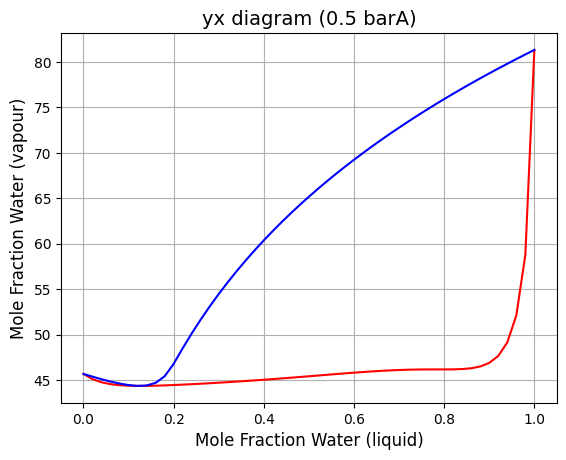

In [67]:
from plotFunctions import plotTxy
plotTxy(plt,x2, TDew,TBub,['THF', 'Water'], yLLE,xInit, P)

### 5.0 Ternary VLLE

#### 5.1 NRTL parameters

Configure the ternary mixture NRTL parameters:

In [111]:
P = distillationPressure['toluene/THF/water'] #1.013 # bar
T = 273.1+72.0                       # Guess temperature for VLLE calculation
x0 = np.array([0.98, 0.01, 0.01])     # Guess values for VLLE molefraction (phase 1)
w0 = np.array([0.01, 0.01, 0.98])     # Guess values for VLLE molefraction (phase 2)
y0 = (x0 + w0)/2                # Guess value for vapour molefraction
xInit= np.array([i for i in moleFractionInitial.values()])
mix = mixture(toluene,THF)
mix.add_component(water)

# Ternary mixture parameters
alpha = np.array([[0.0,                                 NRTL_params['toluene/THF']['cij'],      NRTL_params['toluene/water']['cij']],
                  [NRTL_params['toluene/THF']['cji'],   0.0,                                    NRTL_params['THF/water']['cij']],
                  [NRTL_params['toluene/water']['cji'], NRTL_params['THF/water']['cji'],        0.0]])

Aij0 = np.array([[0.0,                                  NRTL_params['toluene/THF']['bij'],      NRTL_params['toluene/water']['bij']],
                 [NRTL_params['toluene/THF']['bji'],    0.0,                                    NRTL_params['THF/water']['bij']],
                 [NRTL_params['toluene/water']['bji'],  NRTL_params['THF/water']['bji'],        0.0]])

Aij1 = np.array([[0.0,                                  NRTL_params['toluene/THF']['aij'],      NRTL_params['toluene/water']['aij']],
               [NRTL_params['toluene/THF']['aji'],      0.0,                                    NRTL_params['THF/water']['aij']],
               [NRTL_params['toluene/water']['aji'],    NRTL_params['THF/water']['aji'],        0.0]])

mix.NRTL(alpha, Aij0, Aij1)
eos = virialgamma(mix, virialmodel='ideal_gas', actmodel='nrtl')  # no virial model, therefore 'ideal gas'


# Tbubble = bubbleTy(y0, T0, xInit, P, eos, full_output=True).T
# print(Tbubble)

#### 5.2 Vapour and liquid-liquid compositions at the bubble-point of the initial (feed) mixture

The feed mixture lies within the liquid-liquid region of the ternary mixture. Calculate the equilbrium conditions (bubble-point, phase compositions) at the given initial vessel composition. This is done by iterating via "fsolve" on the 3-phase flash calculation unntil the vapour fraction = 0 (definition of the bubble point of the mixture.)

In [112]:
P = distillationPressure['toluene/THF/water'] #1.013 # bar
TGuess = 323
print("TGuess: ", TGuess)
TEq, = fsolve(lambda T: vlle(x0, w0, y0, xInit, T, P, eos, K_tol=1e-11, full_output=True).beta[2], TGuess, xtol=1e-8)
VLLE = vlle(x0, w0, y0, xInit, TEq, P, eos, K_tol=1e-11, full_output=True)
TEq=VLLE.T #[3]
xL1=VLLE.X[0]
xL2=VLLE.X[1]
yEq=VLLE.X[2]
print(VLLE)
print()
print("Phase 1 molefraction:  " + ", ".join("%.4f" % f for f in (xL1) ) )
print("Phase 2 molefraction:  " + ", ".join("%.4f" % f for f in (xL2) ) )
print("Vapour molefraction:   " + ", ".join("%.4f" % f for f in (yEq) ) )
print('Liquid temperature:    {:0.4f} C'.format( TEq-273.2) )


TGuess:  323
           T: 323.0
           P: 0.5
 error_outer: 2.591638048821391e-12
 error_inner: 2.858634156197764e-10
        iter: 12
        beta: array([0.83163069, 0.16836931, 0.        ])
       tetha: array([0.        , 0.        , 0.21105421])
           X: array([[5.82710450e-01, 4.10212768e-01, 7.07678161e-03],
       [1.82416143e-04, 1.97551120e-02, 9.80062472e-01],
       [1.67628099e-01, 5.34887702e-01, 2.97484199e-01]])
           v: [None, None, None]
      states: ['L', 'L', 'V']

Phase 1 molefraction:  0.5827, 0.4102, 0.0071
Phase 2 molefraction:  0.0002, 0.0198, 0.9801
Vapour molefraction:   0.1676, 0.5349, 0.2975
Liquid temperature:    49.8000 C


#### 5.3 Tie-lines for VLLE

Calculate tie-lines and vapour line for ternary diagram:

In [79]:
# Tie-lines and vapour-line for ternary diagram
P = distillationPressure['toluene/THF/water'] #1.013 # bar
zTHFList =      [0.01, .017, .025,  .05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.50]
TGuessList   =  [343,   343, 343,   343, 343, 343,  323, 323, 323, 323]
xL1List=[[],[]]
xL2List=[[],[]]
yList=[[],[]]
TList=[]
zList = [np.array([0.1,z,1-.1-z]) for z in zTHFList]
# zList.append(np.array([moleFractionInitial['toluene'],moleFractionInitial['THF'],moleFractionInitial['water']]))
# zList.append(np.array([0.05,0.55,1-0.05-0.55]))
# TGuessList.append(273.2+63)
# TGuess=363 # 362
for z,TGuess in zip(zList, TGuessList):
    # Tsurf = fsolve(lambda T: vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True).beta[2], 344.7, xtol=1e-3)
    Tsurf = fsolve(lambda T: vlle(x0, w0, y0, z, T, P, eos, K_tol=1e-11, full_output=True).beta[2], TGuess, xtol=1e-8) # 344.7
    VLLE = vlle(x0, w0, y0, z, Tsurf, P, eos, K_tol=1e-11, full_output=True)
    TLiq=VLLE.T #[3]
    # TGuess = TLiq
    xL1=VLLE.X[0]
    xL2=VLLE.X[1]
    yLLE=VLLE.X[2]
    xL1List[0].append(xL1[0])
    xL1List[1].append(xL1[1])
    xL2List[0].append(xL2[0])
    xL2List[1].append(xL2[1])

    # xL2List.append([xL2[1],xL2[2]])
    yList[0].append(yLLE[0])
    yList[1].append(yLLE[1])
    TList.append(TLiq-273.2)

#### 5.4 Residue Curves

The residue curves for the mixture are calculated by numerically integrating the residue curve (simple distillation) equation forwards & backwards in dimensionless time.

In [40]:
# Residue-curve map (VL only)

def RCM( t,x ):
    x[0] = x[0]/(x[0] + x[1] + x[2])
    x[1] = x[1]/(x[0] + x[1] + x[2])
    x[2] = x[2]/(x[0] + x[1] + x[2])

    T = bubbleTy(y0[0:3], T0, x[0:3], P, eos, full_output=True).T
    x = [x[0],x[1],x[2]]

    gam1 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[0] )
    gam2 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[1] )
    gam3 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[2] )

    y1 = x[0]* gam1 * toluene.psat(T) /P
    y2 = x[1]* gam2 * THF.psat(T) /P
    y3 = x[2]* gam3 * water.psat(T) /P

    dxdt =  [   (x[0]-y1),
                (x[1]-y2),
                (x[2]-y3),
                 P - x[0]*gam1*toluene.psat(T) - x[1]*gam2*THF.psat(T) - x[2]*gam3*water.psat(T)]

    return dxdt

from scipy.integrate import ode
import time

P = distillationPressure['toluene/THF/water'] #1.013 # bar
pts = [[0.1,0.1,0.8],[0.2,0.1,0.7],[0.3,0.1,0.6]]
# pts = [xInit]
pts = [[0.05,0.85,0.1],[.05,.6,.35]]
xFp = [[0,0],[1,0],azeotropes['THF/water']] # Pure toluene, pure water, THF/water azeotrope
y0 = np.array([0.3, 0.3, 0.4])

residueCurvesFwd = {'x1': [], 'x2': [] }
residueCurvesBwd = {'x1': [], 'x2': [] }

for pt in pts:

    tInteg = 60
    fPapproach = 0.02
    fwd = 1
    bwd = 1
    Z=np.array([pt[0],pt[1],1-pt[0]-pt[1]])
    Tbubble = bubbleTy(y0[0:3], T0, Z, P, eos, full_output=True).T # vapor fractions, temperature
    IC = np.transpose([pt[0], pt[1], 1-pt[0]-pt[1], Tbubble])

    # Using bdf integration method
    # ============================

    t = []
    x1= []  
    x2 = []

    if fwd:
        x1f = []
        x2f = []
        x3f = []
        Tf = []
        x1f.append(IC[0])
        x2f.append(IC[1])
        r1 = ode(RCM).set_integrator('vode', method='bdf', with_jacobian=False)
        y0, t0 = IC, 0
        r1.set_initial_value(y0, t0)
        xendCurr = r1.y.tolist()[0]
        yendCurr = r1.y.tolist()[1]
        t1 = tInteg
        dt = .05
        while r1.successful() and r1.t < t1 \
            and np.sqrt( (xendCurr-xFp[0][0])**2 + (yendCurr-xFp[0][1])**2) / np.sqrt(2) > fPapproach \
            and np.sqrt( (xendCurr-xFp[1][0])**2 + (yendCurr-xFp[1][1])**2) / np.sqrt(2) > fPapproach \
            and np.sqrt( (xendCurr-xFp[2][0])**2 + (yendCurr-xFp[2][1])**2) / np.sqrt(2) > fPapproach :
            r1.integrate(r1.t+dt)
            xendCurr = r1.y.tolist()[0]
            yendCurr = r1.y.tolist()[1]
            t.append(r1.t)
            x1f.append( np.real(r1.y.tolist()[0]) )
            x2f.append( np.real(r1.y.tolist()[1]) )
            x3f.append( np.real(r1.y.tolist()[2]) )
            Tf.append( np.real(r1.y.tolist()[3]) )
    residueCurvesFwd['x1'].append(x1f)
    residueCurvesFwd['x2'].append(x2f)

    if bwd:
        x1b = []
        x2b = []
        x3b = []
        Tb = [] 
        x1b.append(IC[0])
        x2b.append(IC[1])

        r2 = ode(RCM).set_integrator('vode', method='bdf', with_jacobian=False)
        y0, t0 = IC, 0
        t1 = tInteg
        r2.set_initial_value(y0, t1)
        xendCurr = r2.y.tolist()[0]
        yendCurr = r2.y.tolist()[1]
        dt = -.1
        while r2.successful() and r2.t > 0 \
            and np.sqrt( (xendCurr-xFp[0][0])**2 + (yendCurr-xFp[0][1])**2) / np.sqrt(2) > fPapproach \
            and np.sqrt( (xendCurr-xFp[1][0])**2 + (yendCurr-xFp[1][1])**2) / np.sqrt(2) > fPapproach:
            #and np.sqrt( (xendCurr-xFp[2][0])**2 + (yendCurr-xFp[2][1])**2) / np.sqrt(2) > fPapproach :
            r2.integrate(r2.t+dt)
            xendCurr = r2.y.tolist()[0]
            yendCurr = r2.y.tolist()[1]
            t.append(r2.t)
            x1b.append( np.real(r2.y.tolist()[0]) )
            x2b.append( np.real(r2.y.tolist()[1]) )
            x3b.append( np.real(r2.y.tolist()[2]) )
            Tb.append( np.real(r2.y.tolist()[3]) )

    residueCurvesBwd['x1'].append(x1b)
    residueCurvesBwd['x2'].append(x2b)
    print('Done')


Done
Done


Residue curve map, accounting for possibility of two liquid phases

In [23]:
# Residue-curve map for LL

def RCM_VLL( t,x ):
    x[0] = x[0]/(x[0] + x[1] + x[2])
    x[1] = x[1]/(x[0] + x[1] + x[2])
    x[2] = x[2]/(x[0] + x[1] + x[2])

    TGuess = 363
    # print("TGuess: ", TGuess)
    TEq, = fsolve(lambda T: vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True).beta[2], TGuess, xtol=1e-8)
    print("TEq: ", TEq)
    VLLE = vlle(x0, w0, y0, Z, TEq, P, eos, K_tol=1e-11, full_output=True)
    TEq=VLLE.T #[3]
    xL1=VLLE.X[0]
    xL2=VLLE.X[1]
    yEq=VLLE.X[2]

    # T = bubbleTy(y0[0:3], T0, x[0:3], P, eos, full_output=True).T
    # x = [x[0],x[1],x[2]]

    # gam1 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[0] )
    # gam2 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[1] )
    # gam3 = np.exp( nrtl(x,T,alpha, Aij0, Aij1)[2] )

    y1 = x[0]* gam1 * toluene.psat(T) /P
    y2 = x[1]* gam2 * THF.psat(T) /P
    y3 = x[2]* gam3 * water.psat(T) /P

    dxdt =  [   (x[0]-y1),
                (x[1]-y2),
                (x[2]-y3),
                 P - x[0]*gam1*toluene.psat(T) - x[1]*gam2*THF.psat(T) - x[2]*gam3*water.psat(T)]

    return dxdt


from scipy.integrate import ode
import time

pts = [[0.1,0.1,0.8],[0.2,0.1,0.7],[0.3,0.1,0.6]]
# pts = [xInit]
pts = [[0.05,0.85,0.1],[.05,.6,.35]]
xFp = [[0,0],[1,0],azeotropes['THF/water']] # Pure toluene, pure water, THF/water azeotrope
y0 = np.array([0.3, 0.3, 0.4])

residueCurvesFwd = {'x1': [], 'x2': [] }
residueCurvesBwd = {'x1': [], 'x2': [] }

for pt in pts:

    tInteg = 60
    fPapproach = 0.02
    fwd = 1
    bwd = 1
    Z=np.array([pt[0],pt[1],1-pt[0]-pt[1]])
    # Tbubble = bubbleTy(y0[0:3], T0, Z, P, eos, full_output=True).T # vapor fractions, temperature
    TGuess = 363
    # print("TGuess: ", TGuess)
    TEq, = fsolve(lambda T: vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True).beta[2], TGuess, xtol=1e-8)
    print("TEq: ", TEq)
    VLLE = vlle(x0, w0, y0, Z, TEq, P, eos, K_tol=1e-11, full_output=True)
    TEq=VLLE.T #[3]
    xL1=VLLE.X[0]
    xL2=VLLE.X[1]
    yEq=VLLE.X[2]


    IC = np.transpose([pt[0], pt[1], 1-pt[0]-pt[1], TEq])

    # Using bdf integration method
    # ============================

    t = []
    x1= []  
    x2 = []

    if fwd:
        x1f = []
        x2f = []
        x3f = []
        Tf = []
        x1f.append(IC[0])
        x2f.append(IC[1])
        r1 = ode(RCM_VLL).set_integrator('vode', method='bdf', with_jacobian=False)
        y0, t0 = IC, 0
        r1.set_initial_value(y0, t0)
        xendCurr = r1.y.tolist()[0]
        yendCurr = r1.y.tolist()[1]
        t1 = tInteg
        dt = .05
        while r1.successful() and r1.t < t1 \
            and np.sqrt( (xendCurr-xFp[0][0])**2 + (yendCurr-xFp[0][1])**2) / np.sqrt(2) > fPapproach \
            and np.sqrt( (xendCurr-xFp[1][0])**2 + (yendCurr-xFp[1][1])**2) / np.sqrt(2) > fPapproach \
            and np.sqrt( (xendCurr-xFp[2][0])**2 + (yendCurr-xFp[2][1])**2) / np.sqrt(2) > fPapproach :
            r1.integrate(r1.t+dt)
            xendCurr = r1.y.tolist()[0]
            yendCurr = r1.y.tolist()[1]
            t.append(r1.t)
            x1f.append( np.real(r1.y.tolist()[0]) )
            x2f.append( np.real(r1.y.tolist()[1]) )
            x3f.append( np.real(r1.y.tolist()[2]) )
            Tf.append( np.real(r1.y.tolist()[3]) )
    residueCurvesFwd['x1'].append(x1f)
    residueCurvesFwd['x2'].append(x2f)

    if bwd:
        x1b = []
        x2b = []
        x3b = []
        Tb = [] 
        x1b.append(IC[0])
        x2b.append(IC[1])

        r2 = ode(RCM_VLL).set_integrator('vode', method='bdf', with_jacobian=False)
        y0, t0 = IC, 0
        t1 = tInteg
        r2.set_initial_value(y0, t1)
        xendCurr = r2.y.tolist()[0]
        yendCurr = r2.y.tolist()[1]
        dt = -.1
        while r2.successful() and r2.t > 0 \
            and np.sqrt( (xendCurr-xFp[0][0])**2 + (yendCurr-xFp[0][1])**2) / np.sqrt(2) > fPapproach \
            and np.sqrt( (xendCurr-xFp[1][0])**2 + (yendCurr-xFp[1][1])**2) / np.sqrt(2) > fPapproach:
            #and np.sqrt( (xendCurr-xFp[2][0])**2 + (yendCurr-xFp[2][1])**2) / np.sqrt(2) > fPapproach :
            r2.integrate(r2.t+dt)
            xendCurr = r2.y.tolist()[0]
            yendCurr = r2.y.tolist()[1]
            t.append(r2.t)
            x1b.append( np.real(r2.y.tolist()[0]) )
            x2b.append( np.real(r2.y.tolist()[1]) )
            x3b.append( np.real(r2.y.tolist()[2]) )
            Tb.append( np.real(r2.y.tolist()[3]) )

    residueCurvesBwd['x1'].append(x1b)
    residueCurvesBwd['x2'].append(x2b)
    print('Done')


TEq:  363.0


c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\multiflash.py:16: RuntimeWarning: overflow encountered in exp
  Kexp = K.T*np.exp(tetha)
c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\multiflash.py:22: RuntimeWarning: invalid value encountered in multiply
  f2 = (K1.T*Xref).sum(axis=1)
c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\multiflash.py:35: RuntimeWarning: invalid value encountered in multiply
  ter1 = Xref/sum1 * K1.T
c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\multiflash.py:36: RuntimeWarning: invalid value encountered in matmul
  dfb = - ter1@K1
c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\multiflash.py:38: RuntimeWarning: invalid value encounter

Exception: Composition vector lenght must be equal to nc

#### 5.5 Configure Ternary Diagram

In [81]:
# Plot ternary map

from scipy.interpolate import CubicSpline

def plotTernaryMap(Components,Z,yEq,x1,x2,y,TList,azeotropes,x1b,x2b,x1f,x2f,residueCurvesFwd, residueCurvesBwd,P):
    fntsz = 14
    legendfntsz = 12
    labelfntsz = 18

    # fig, ax = plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.axis([0, 1, 0, 1])
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(True)
    cur_axes.axes.get_yaxis().set_visible(True)

    cur_axes.spines['bottom'].set_color('k')
    cur_axes.spines['top'].set_color('w')
    cur_axes.spines['right'].set_color('w')
    cur_axes.spines['left'].set_color('k')
    plt.plot([1, 0, ], [0, 1], '-k', linewidth=.5)

    # Plot initial (overall) composition
    plt.plot(Z[0],Z[1],'ok')
    plt.plot(yEq[0],yEq[1],'sk')

    for x1plot,x2plot,y1plot,y2plot in zip(x1[0],x2[0],x1[1],x2[1]):
        plt.plot([x1plot,x2plot],[y1plot,y2plot],'-b')
        plt.plot(x1plot,y1plot,'.r')
        plt.plot(x2plot,y2plot,'.r')
    
    # Prepend verticex values (1 or zero) to allow vertices to be included
    x1_0 = [1] + x1[0]
    x1_1 = [0] + x1[1]
    x2_0 = [0] + x2[0]   # 1 for RHS
    x2_1 = [0] + x2[1]

    for i in range(0, len(x1_0), 1):
        # pass
        plt.plot(x1_0[i:i+2], x1_1[i:i+2], '-r')

    for i in range(0, len(x2_0 ), 1):
        # pass
        plt.plot(x2_0[i:i+2], x2_1[i:i+2], '-r')

    for x,y in zip(y[0],y[1]):
        plt.plot(x,y,'.b')

    for x1plot,x2plot,y1plot,y2plot,T in zip(x1[0],x2[0],x1[1],x2[1],TList):
        t = plt.text((x1plot+x2plot)/2,(y1plot+y2plot)/2, np.round(T[0],2), transform=ax.transAxes, fontsize=10)
        t.set_bbox(dict(facecolor='white', alpha=0.9, linewidth=0))
        # plt.plot(x2plot,y2plot,'.r')

    plt.text(0.5, 0.6, "Pressure: "+str(P)+" (barA)", fontsize=fntsz)

    plt.text(1, -.1, Components[2], fontsize=fntsz)
    plt.text(-.05, 1.05, Components[1], fontsize=fntsz)
    plt.text(-.05, -.1, Components[0], fontsize=fntsz)
    plt.xticks(fontsize=fntsz)
    plt.yticks(fontsize=fntsz)
    # plt.xlim(-0.1, 1.1)
    # plt.ylim(-0.1, 1.1)

    plt.plot(0,azeotropes['THF/water'][0],'ob')
    plt.plot(azeotropes['toluene/water'][0],0,'ob')

    # Plot residue curve2
    for x1,x2 in zip(residueCurvesFwd['x1'],residueCurvesFwd['x2']):
        plt.plot(x1,x2,'-k',linewidth=.5)
    for x1,x2 in zip(residueCurvesBwd['x1'],residueCurvesBwd['x2']):
        plt.plot(x1,x2,'-k',linewidth=.5)
                     
                     
    # plt.plot(x1b,x2b,'-k')
    # plt.plot(x1f,x2f,'-k')

    # plt.plot([0,  1.0],[0.0,  0.0],'k')
    plt.plot([0, 0.9], [0.1, 0.1], '--k', linewidth=.5)
    plt.plot([0, 0.8], [0.2, 0.2], '--k', linewidth=.5)
    plt.plot([0, 0.7], [0.3, 0.3], '--k', linewidth=.5)
    plt.plot([0, 0.6], [0.4, 0.4], '--k', linewidth=.5)
    plt.plot([0, 0.5], [0.5, 0.5], '--k', linewidth=.5)
    plt.plot([0, 0.4], [0.6, 0.6], '--k', linewidth=.5)
    plt.plot([0, 0.3], [0.7, 0.7], '--k', linewidth=.5)
    plt.plot([0, 0.2], [0.8, 0.8], '--k', linewidth=.5)
    plt.plot([0, 0.1], [0.9, 0.9], '--k', linewidth=.5)
    #   Plot Y gridlines
    plt.plot([0.1, 0.1], [0.0, 0.9], '--k', linewidth=.5)
    plt.plot([0.2, 0.2], [0.0, 0.8], '--k', linewidth=.5)
    plt.plot([0.3, 0.3], [0.0, 0.7], '--k', linewidth=.5)
    plt.plot([0.4, 0.4], [0.0, 0.6], '--k', linewidth=.5)
    plt.plot([0.5, 0.5], [0.0, 0.5], '--k', linewidth=.5)
    plt.plot([0.6, 0.6], [0.0, 0.4], '--k', linewidth=.5)
    plt.plot([0.7, 0.7], [0.0, 0.3], '--k', linewidth=.5)
    plt.plot([0.8, 0.8], [0.0, 0.2], '--k', linewidth=.5)
    plt.plot([0.9, 0.9], [0.0, 0.1], '--k', linewidth=.5)

Plot ternary diagram showing the liquid-liquid region. The tie-lines are indicate with the corresponding liquid temperature. Vapour line is represented by blue dots.

The initial composition (black dot) is on a tie-line with a boiling temperature of 79C; the corresponding vapour composition is a black square.

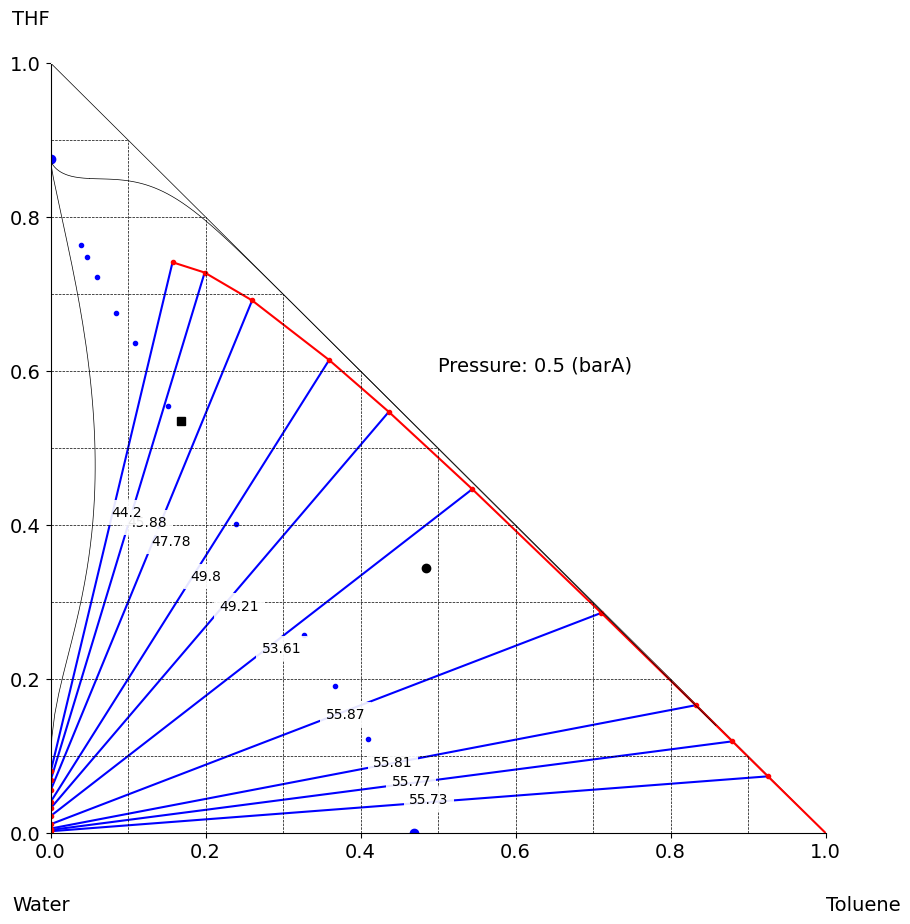

In [92]:
plotTernaryMap(['Water','THF','Toluene',],[moleFractionInitial['toluene'],moleFractionInitial['THF']], yEq, xL1List, xL2List, yList, TList,azeotropes, x1b,x2b,x1f,x2f,residueCurvesFwd,residueCurvesBwd,P)

### 6.0 Case I: Steady-state Jacket Heat Input

#### 6.1 Condenser Inlet Conditions

Flow rate into condenser is determined by the heat input into the vessel jacket, by the composition of the vapour in equilibrium with the initial composition, and by the flowrate of inerts.


In [ ]:
Image(url="condenserMassBalanceTolueneTHFWaterWithReactor.png",width=1000)


The vapour composition i.e. the composition of the vapour on the vapour line corresponding to the tie-line that passes through the initial composition is:

In [93]:
# print("Vapour composition (molefraction) :", yEq )
print ("Binary composition (molefraction):", '[%s]' % ', '.join(map(str, ["%.3f" % float(elem) for elem in yEq] )))

Binary composition (molefraction): [0.168, 0.535, 0.297]


The heat input into the jacket is an assumed value:

In [94]:
Qin = 200*1000 # Watts
from IPython.display import Markdown as md
md("Heat input duty: {} kW".format(Qin/1000))

Heat input duty: 200.0 kW

Added to the flow of solvents will be an allowance for flow of inerts which leak into vessel under vacuum.

In [95]:
mAir = 2.72/3600 # kg/s
MWAir = 0.02896 # kg/mol
nAir = mAir/MWAir 
print("Mass flowrate of air:   {:0.3f} kg/hr".format(mAir*3600) )
print("Molar flowrate of air:  {:0.3f} kmol/hr".format(nAir*3600/1000))

Mass flowrate of air:   2.720 kg/hr
Molar flowrate of air:  0.094 kmol/hr


Calculate boilup rate based on initial composition and jacket heat-input $Q_{in}$:

In [98]:
from thermo import *
import functools
# constants, properties = ChemicalConstantsPackage.from_IDs(['toluene', 'tetrahydrofuran','water', 'nitrogen'])

print("Latent heat of toluene:  {:0.1f} J/mol".format(Chemical('toluene').EnthalpyVaporization(298) ) )
print("Latent heat of THF:      {:0.1f} J/mol".format(Chemical('tetrahydrofuran').EnthalpyVaporization(298) ) )
print("Latent heat of water:    {:0.1f} J/mol".format(Chemical('water').EnthalpyVaporization(298) ) )

dHVL  = moleFractionInitial['toluene']*Chemical('toluene').EnthalpyVaporization(273+20) + \
        moleFractionInitial['THF']*Chemical('tetrahydrofuran').EnthalpyVaporization(273+20) + \
        moleFractionInitial['water']*Chemical('water').EnthalpyVaporization(273+20)
print("Weighted average (20C):  {:0.1f} J/mol".format(dHVL))

moleFlowSolvent = Qin/dHVL  # mol/s
moleFlowInletTotal = moleFlowSolvent + nAir

moleFlowInlet = {'toluene':  moleFlowSolvent*yEq[0],
                 'THF':      moleFlowSolvent*yEq[1],
                 'water':    moleFlowSolvent*yEq[2],
                 'inerts':   nAir} 

moleFractionInlet = {   'toluene':      moleFlowInlet["toluene"]/moleFlowInletTotal,
                        'THF':          moleFlowInlet["THF"]/moleFlowInletTotal,
                        'water':        moleFlowInlet["water"]/moleFlowInletTotal,
                        'inerts':       moleFlowInlet["inerts"]/moleFlowInletTotal} 

MWAvg = moleFractionInlet['toluene']*Chemical('toluene').MW +moleFractionInlet['THF']*Chemical('tetrahydrofuran').MW +moleFractionInlet['water']*Chemical('water').MW + moleFractionInlet['inerts']*Chemical('nitrogen').MW

print("Average molecular weight:        {:0.1f} gm/mol".format(MWAvg))
print()
print("Solvent flowrate:                {:0.3f} mol/s".format(moleFlowSolvent) )
print("Total incl. non-condensibles:    {:0.3f} mol/s".format(moleFlowInletTotal ) )
print("Vapour inlet flow to condensers: {:0.1f} kg/hr".format(moleFlowInletTotal *MWAvg*3600/1000))
print("Inlet temperature:               {:0.2f} C: ".format( TEq-273.2) )
print()

print("Toluene inlet flow:              {:0.3f} mol/s: ".format(moleFlowInlet["toluene"]) )
print("THF inlet flow:                  {:0.3f} mol/s".format(moleFlowInlet["THF"]) )
print("Water inlet flow:                {:0.3f} mol/s".format(moleFlowInlet["water"]) )
print("Inerts inlet flow:               {:0.3f} mol/s".format(moleFlowInlet["inerts"]) )         
print()

print("Toluene inlet molefraction:      {:0.3f} ".format(moleFractionInlet["toluene"]) )
print("THF inlet molefraction:          {:0.3f} ".format(moleFractionInlet["THF"]) )
print("Water inlet molefraction:        {:0.3f} ".format(moleFractionInlet["water"]) )
print("Inerts molefraction:             {:0.4f} ".format(moleFractionInlet["inerts"]) ) 



    

Latent heat of toluene:  38047.7 J/mol
Latent heat of THF:      31978.6 J/mol
Latent heat of water:    43993.9 J/mol
Weighted average (20C):  37225.3 J/mol
Average molecular weight:        59.2 gm/mol

Solvent flowrate:                5.373 mol/s
Total incl. non-condensibles:    5.399 mol/s
Vapour inlet flow to condensers: 1151.0 kg/hr
Inlet temperature:               49.80 C: 

Toluene inlet flow:              0.901 mol/s: 
THF inlet flow:                  2.874 mol/s
Water inlet flow:                1.598 mol/s
Inerts inlet flow:               0.026 mol/s

Toluene inlet molefraction:      0.167 
THF inlet molefraction:          0.532 
Water inlet molefraction:        0.296 
Inerts molefraction:             0.0048 


#### 6.2 Simulation of the Condensation of Immiscible Liquid Mixture

The configuration of a single condenser is depicted below. In the case of toluene/THF/water, separate liquid phases are expected, indicated by the flowrates $L_I$ and $L_{II}$, which combine to give an overall condensate flow of $L$.

The pressure $P$ is specified, as is the operating temperature $T$, which is assumed to approach the glycol inlet temperature to a specified extent.

In [ ]:
Image(url="condenserMassBalanceTolueneTHFWater.png",width=1000)

Equilibrium between the 2 liquid phases is given by (ref. Smith & van Ness p. 460):

$$
x_{toluene}^I \gamma_{toluene}^I  = x_{Dtoluene}^{II} \gamma_{toluene}^{II}
$$
$$
x_{THF}^I \gamma_{THF}^I  = x_{THF}^{II} \gamma_{THF}^{II}
$$
$$
x_{H2O}^I \gamma_{H2O}^I  = x_{H2O}^{II} \gamma_{H2O}^{II}
$$
where $I$ and $II$ represent the separate liquid phases in equilibrium. In each case, $\gamma$ is a function of composition and temperature.

A summation on molefraction in each phase is:
$$
x_{water}^I = 1- x_{toluene}^{I} - x_{THF}^{I}
$$
and
$$
x_{water}^{II} = 1- x_{toluene}^{II} - x_{THF}^{II}
$$
Vapour-liquid-liquid equilibrium (VLLE) is given by:

$$
y_{toluene} = \frac{x_{toluene}^{I} \gamma_{toluene}^{I}  p_{toluene}^S(T)}{P}
$$
$$
y_{THF} = \frac{x_{THF}^{II} \gamma_{THF}^{II}  p_{THF}^S(T)}{P}
$$
$$
y_{H2O} = \frac{x_{H2O}^{II} \gamma_{H2O}^{II}  p_{H2O}^S(T)}{P}
$$
where $p_{toluene}^S$, $p_{THF}^S$ and $p_{water}^S$ are pure-component vapour pressures, and $P$ is total pressure.  Note that $y_{toluene}$ and $y_{water)}$ are calculated from the phases in which the respective liquids are the main component, phases $I$ and $II$ respectively.  $y_{THF}$ is arbitrarily based on the composition in phase $II$.

A summation of vapour molefraction is:
$$
y_{inerts} = 1- y_{toluene}-y_{THF}- y_{H2O}
$$

An overall mass balance is given by:
$$
\Sigma F_i^{IN} = \Sigma G_i^{OUT} + L_{I} + L_{II}
$$
where $F_i^{IN}$ are the component molar feed inputs to the condenser, $G_i^{OUT}$ are component molar flowrates in vapour exiting. $L_{I}$ and $L_{II}$ are the molar flowrates of the separate liquid condensate phases.

Finally, component molar balances are given by:
$$
L_{I}x_{toluene}^I + L_{II}x_{toluene}^II = F_{toluene}^{IN} - G_{toluene}^{OUT}
$$
for toluene, by
$$
L_{I}x_{THF}^I + L_{II}x_{THF}^II = F_{THF}^{IN} - G_{THF}^{OUT}
$$
for THF, and for H2O by:
$$
L_{I}x_{H2O}^I + L_{II}x_{H2O}^II = F_{H2O}^{IN} - G_{H2O}^{OUT}
$$

The above represents 14 non-linear equations in 14 unknowns: $L_{I}$, $L_{II}$, $x_{toluene}^I$,  $x_{toluene}^{II}$, $x_{THF}^I$,  $x_{THF}^{II}$,  $x_{H2O}^I$,  $x_{H2O}^{II}$,  $y_{toluene}$,  $y_{THF}$,  $y_{H2O}$, $y_{INERTS}$, and  $G_{OUT}$.  
  


#### 6.3 Numerical Solution of Condensation Model

The system of equations is solved numerically below in the "pyomo" framework, using the IPOPT solver. Mass balance tables below are for gas exiting at -10C.

In [115]:
# Pyomo model for partial condenser with two liquid phases
from pyomo.environ import *
from tabulate import tabulate
from phasepy.actmodels import nrtl

print("Inlet vapour conditions at {:0.2f} C: ".format(TEq-273.2) )

inlet_conditions = [
    ["Toluene", np.round(moleFlowInlet["toluene"],3),       toluene.Mw,         np.round(moleFractionInlet["toluene"],3), np.round(moleFractionInlet["toluene"]*P,3)],
    ["THF",     np.round(moleFlowInlet["THF"],3),           THF.Mw,             np.round(moleFractionInlet["THF"],3),     np.round(moleFractionInlet["THF"]*P,3)],
    ["Water",   np.round(moleFlowInlet["water"],3),         water.Mw,           np.round(moleFractionInlet["water"],3),  np.round(moleFractionInlet["water"]*P,3)],
    ["Inerts",  np.round(moleFlowInlet["inerts"],3),        28.0,               np.round(moleFractionInlet["inerts"],3),  np.round(moleFractionInlet["inerts"]*P,3)],
    ["Total:",  np.round(moleFlowInletTotal,3),             np.round(MWAvg,2),  "{:.4f}".format(sum(moleFractionInlet.values())),  "{:.4f}".format(sum(moleFractionInlet.values())*P)]
]


table = tabulate(inlet_conditions, headers=["Component","Inlet flow (mol/s)", "Molecular Weight", \
                                  "Mole fraction","Partial Pressure (bar)",],\
                                    tablefmt='html',disable_numparse=True)

from IPython.display import HTML, display
display(HTML(table))

P = distillationPressure['toluene/THF/water'] #1.013 # bar

L1List=[]
L2List=[]
ventFlow={'toluene':[],'THF':[],'water':[],'inerts':[]}
percentCondensedDict ={'toluene':[],'THF':[],'water':[],'inerts':[]}
condensateMolefraction = {'toluene':[],'THF':[],'water':[] }
ventMolefraction = {'toluene':[],'THF':[],'water':[],'inerts':[]  }

condenserTemperatureList=[35+273.2, 30+273.2, 25+273.2, 20+273.2, 15+273.2, 10+273.2, 5+273.2, 0+273.2, -5+273.2, -10+273.2] #, , 5+273.2, 10+273.2, 15+273.2] #,15,10,5,0,-5,-10,-15]
for T in condenserTemperatureList:
    m = ConcreteModel()

    ## Define the objective to be a constant
    m.obj = Objective(expr=1)

    ## Define a set for components
    # ----------------------------
    m.COMPS = Set(initialize=["toluene","THF","water"])

    ################
    ## Parameters
    ################
    m.F_in = Param(initialize=moleFlowInletTotal)
    m.z = Param(m.COMPS, initialize={"toluene":moleFractionInlet["toluene"], "THF":moleFractionInlet["THF"], "water":moleFractionInlet["water"]})

    # m.P = P
    m.P = Param(within=NonNegativeReals,initialize=P)
    m.T = Param(within=NonNegativeReals,mutable=True,initialize=T) #
    # print("Temperature  {:6.1f} [K]".format(value(m.T)))

    ################
    ## Variables
    ################
    m.xL1      = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.94, "THF":0.05, "water":0.01})  # variable, indexed by the set "COMPS"
    m.xL2      = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.01, "THF":0.05, "water":0.94})  # variable, indexed by the set "COMPS"
    m.y        = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.80, "THF":0.1, "water":0.10})  # variable, indexed by the set "COMPS"

    m.yInerts       = Var(within=NonNegativeReals, initialize=moleFractionInlet["inerts"]) 
    m.L1            = Var(within=NonNegativeReals, initialize=moleFlowInlet["toluene"]) 
    m.L2            = Var(within=NonNegativeReals, initialize=moleFlowInlet["water"])
    m.F_out         = Var(within=NonNegativeReals, initialize=moleFlowInletTotal)

    ##########################
    ## Constraint declarations
    ##########################
    # equation 1: overall mass balance
    # --------------------------------
    m.overall_mass_balance = Constraint(expr=m.F_in == m.F_out + m.L1 + m.L2)

    # equations 2a / 2b: component mass balances
    # ------------------------------------------
    def eq_comp_mass_balance(m, c):
        ''' model: Pyomo model
            c: set for components
        '''
        return m.F_in*m.z[c] == m.xL1[c]*m.L1 + m.xL2[c]*m.L2 + m.F_out*m.y[c]

    m.component_mass_balance= Constraint(m.COMPS, rule=eq_comp_mass_balance)

    # equation 4a/4b: Liquid-liquid equilibria
    # ----------------------------------------
    m.LLE_eq1 = Constraint( expr=   m.xL1["toluene"]*(  np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ) ) == 
                                    m.xL2["toluene"]*(  np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[0] )  ) )

    m.LLE_eq2 = Constraint( expr=   m.xL1["THF"]*(      np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ) ) == 
                                    m.xL2["THF"]*(      np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[1] )  ) )
    
    m.LLE_eq3 = Constraint( expr=   m.xL1["water"]*(    np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[2] ) ) == 
                                    m.xL2["water"]*(    np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )  ) )
    
        
    # equation 5a/5b/5c: molefraction summation constraints
    # ----------------------------------
    m.summation_L1 = Constraint( expr= m.xL1["toluene"] + m.xL1["THF"]  + m.xL1["water"] == 1 )
    m.summation_L2 = Constraint( expr= m.xL2["toluene"] + m.xL2["THF"]  + m.xL2["water"] == 1 )
    m.summation_V  = Constraint( expr= m.y["toluene"]   + m.y["THF"]    + m.y["water"] +m.yInerts == 1 )

    # equation 6a/6b: Vapour-liquid equilibria
    # ----------------------------------------
    m.VLE1  = Constraint( expr= m.y["toluene"]  == m.xL1["toluene"]*np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ) *toluene.psat(m.T.value) /m.P )   
    m.VLE2  = Constraint( expr= m.y["THF"]      == m.xL1["THF"]*np.exp(     nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ) *THF.psat(m.T.value) /m.P ) 
    m.VLE3  = Constraint( expr= m.y["water"]    == m.xL2["water"]*np.exp(   nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] ) *water.psat(m.T.value) /m.P )

    ## Print model
    # m.pprint()

    #############
    ## Solver
    #############
    solver = SolverFactory('ipopt')
    results = solver.solve(m, tee = False)

    gammaI  = { 'toluene':  np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'THF':      np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ),
                'water':    np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )} 
    
    gammaII = { 'toluene':  np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'THF':      np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ),
                'water':    np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )} 

    percentCondensed = {'toluene':   100*(1-value(m.F_out)*value(m.y["toluene"])/moleFlowInlet["toluene"]),
                        'THF':       100*(1-value(m.F_out)*value(m.y["THF"])/moleFlowInlet["THF"]),
                        'water':     100*(1-value(m.F_out)*value(m.y["water"])/moleFlowInlet["water"]),
                        'inerts':    100*(1-value(m.F_out)*value(m.yInerts)/moleFlowInlet["inerts"]),
                        'total':     100*(1-value(m.F_out)/moleFlowInletTotal)}

    L1List.append(value(m.L1))   
    L2List.append(value(m.L2)) 
    ventFlow['toluene'].append(value(m.F_out)*value(m.y["toluene"]))
    ventFlow['THF'].append(value(m.F_out)*value(m.y["toluene"]))
    ventFlow['water'].append(value(m.F_out)*value(m.y["water"]))
    ventFlow['inerts'].append(value(m.F_out)*value(m.yInerts))

    ventMolefraction['toluene'].append(value(m.F_out)*value(m.y["toluene"]))
    ventMolefraction['THF'].append(value(m.F_out)*value(m.y["THF"]))
    ventMolefraction['water'].append(value(m.F_out)*value(m.y["water"]))
    ventMolefraction['inerts'].append(value(m.F_out)*value(m.yInerts))

    percentCondensedDict['toluene'].append( percentCondensed['toluene'] )
    percentCondensedDict['THF'].append( percentCondensed['THF'] )
    percentCondensedDict['water'].append( percentCondensed['water'] )

    condensateMolefraction['toluene'].append( (value(m.L1)*value(m.xL1["toluene"]) + value(m.L2)*value(m.xL2["toluene"]))/( value(m.L1)+value(m.L2) ) )
    condensateMolefraction['THF'].append( (value(m.L1)*value(m.xL1["THF"]) + value(m.L2)*value(m.xL2["THF"]))/( value(m.L1)+value(m.L2) ) )
    condensateMolefraction['water'].append( (value(m.L1)*value(m.xL1["water"]) + value(m.L2)*value(m.xL2["water"]))/( value(m.L1)+value(m.L2) ) )
    
xOut = {    'toluene':  (value(m.L1)*value(m.xL1["toluene"])+value(m.L2)*value(m.xL2["toluene"]))/(value(m.L1)+value(m.L2)),
                'THF':      (value(m.L1)*value(m.xL1["THF"])+value(m.L2)*value(m.xL2["THF"]))/(value(m.L1)+value(m.L2)),
                'water':    (value(m.L1)*value(m.xL1["water"])+value(m.L2)*value(m.xL2["water"]))/(value(m.L1)+value(m.L2))} 


print("Overall Mass Balance at gas/vapour exit temperature of {:0.1f} C: ".format(T-273.2) )
print()
from IPython.display import HTML, display
sumyOut = value(m.y["toluene"])+value(m.y["THF"])+value(m.y["water"])+value(m.yInerts)
condenser_result_table = [
    ["Toluene:",    moleFlowInlet["toluene"],   moleFractionInlet["toluene"],   "{:.4f}".format(value(m.L1)*value(m.xL1["toluene"])),   "{:.4f}".format(value(m.xL1["toluene"])),   "{:.4f}".format(value(m.L2)*value(m.xL2["toluene"])),   "{:.4f}".format(value(m.xL2["toluene"])),  "{:.4f}".format(xOut["toluene"]),   "{:.6e}".format(value(m.F_out)*value(m.y["toluene"])),  "{:.6f}".format(value(m.y["toluene"])), "{:3.4f}".format(percentCondensed['toluene'])],
    ["THF:",        moleFlowInlet["THF"],       moleFractionInlet["THF"],       "{:.4f}".format(value(m.L1)*value(m.xL1["THF"])),       "{:.4f}".format(value(m.xL1["THF"])),       "{:.4f}".format(value(m.L2)*value(m.xL2["THF"])),       "{:.4f}".format(value(m.xL2["THF"])),      "{:.4f}".format(xOut["THF"]),       "{:.6e}".format(value(m.F_out)*value(m.y["THF"])),      "{:.6f}".format(value(m.y["THF"])),     "{:3.4f}".format(percentCondensed['THF'])],
    ["Water:",      moleFlowInlet["water"],     moleFractionInlet["water"],     "{:.4f}".format(value(m.L1)*value(m.xL1["water"])),     "{:.4f}".format(value(m.xL1["water"])),     "{:.4f}".format(value(m.L2)*value(m.xL2["water"])),     "{:.4f}".format(value(m.xL2["water"])),    "{:.4f}".format(xOut["water"]),     "{:.6e}".format(value(m.F_out)*value(m.y["water"])),    "{:.6f}".format(value(m.y["water"])),   "{:.4f}".format(percentCondensed['water'])],
    ["Inerts:",     moleFlowInlet["inerts"],    moleFractionInlet["inerts"],    "N/A",                                                   "N/A",                                     "N/A",                                                  "N/A",                                     "N/A",                       "{:.6f}".format(value(m.F_out)*value(m.yInerts)),       "{:.6f}".format(value(m.yInerts)),      "{:.4e}".format(percentCondensed['inerts'])],
    ["Totals:",     sum(moleFlowInlet.values()), sum(moleFractionInlet.values()),        "{:.4f}".format(value(m.L1)),                    "{:.4f}".format(value(m.xL1["toluene"])+value(m.xL1["THF"])+value(m.xL1["water"])),   "{:.4f}".format(value(m.L2)), "{:.4f}".format(value(m.xL2["toluene"])+value(m.xL2["THF"])+value(m.xL2["water"])) ,   "N/A",  "{:.6f}".format(value(m.F_out)),    sumyOut, "{:.4f}".format(percentCondensed['total'])]
    ]
table = tabulate(condenser_result_table , headers=["Component","Inlet flowrate (mol/s)","Inlet Molefraction", "Phase 1 flowrate (mol/s)", 
                                                "Phase 1 molefraction", "Phase 2 flowrate (mol/s)", "Phase 2 molefraction", "Liquid Flow (total)", "Vent flowrate (mol/s)", "Vent molefraction", "% Condensed"],\
                                    tablefmt='html',floatfmt=".3f")
display(HTML(table))

phases_result_table = [
    ["Inlet",   "{:.4f}".format(sum(moleFlowInlet.values())), "{:.4f}".format(moleFractionInlet["toluene"]), "{:.4f}".format(moleFractionInlet["THF"]), "{:.4f}".format(moleFractionInlet["water"]),"{:.4f}".format(moleFractionInlet["inerts"]), "N/A", "N/A", "N/A"],
    ["Vent",    "{:.4f}".format(value(m.F_out)), "{:.4f}".format(value(m.y["toluene"])), "{:.4f}".format(value(m.y["THF"])), "{:.4f}".format(value(m.y["water"])),"{:.4f}".format(value(m.yInerts)), "N/A", "N/A", "N/A"],
    ["Organic", "{:.4f}".format(value(m.L1)), "{:.4f}".format(value(m.xL1["toluene"])), "{:.4f}".format(value(m.xL1["THF"])), "{:.4f}".format(value(m.xL1["water"])),"N/A", "{:.2f}".format(gammaI["toluene"]), "{:.2f}".format(gammaI["THF"]),"{:.2f}".format(gammaI["water"])],
    ["Aqueous", "{:.4f}".format(value(m.L2)), "{:.4f}".format(value(m.xL2["toluene"])), "{:.4f}".format(value(m.xL2["THF"])), "{:.4f}".format(value(m.xL2["water"])),"N/A", "{:.2f}".format(gammaII["toluene"]), "{:.2f}".format(gammaII["THF"]), "{:.2f}".format(gammaII["water"])],
    ["Total Liquid","{:.4f}".format(value(m.L1)+value(m.L2)), "{:.4f}".format(xOut["toluene"]), "{:.4f}".format(xOut["THF"]), "{:.4f}".format(xOut["water"]),"N/A","N/A","N/A", "N/A"]
]
table = tabulate(phases_result_table , headers=["Phase","Phase flowrate (mol/s)", "Toluene Molefraction", "THF Molefraction", "Water Molefraction", "Inerts Molefraction", "Activity Coefficient (Toluene)", "Activity Coefficient (THF)", "Activity Coefficient (Water)"],\
                                    tablefmt='html')
display(HTML(table))

Inlet vapour conditions at 49.80 C: 


Component,Inlet flow (mol/s),Molecular Weight,Mole fraction,Partial Pressure (bar)
Toluene,0.901,92.14,0.167,0.083
THF,2.874,84.93,0.532,0.266
Water,1.598,18.02,0.296,0.148
Inerts,0.026,28.0,0.005,0.002
Total:,5.399,59.22,1.0000,0.5000


Overall Mass Balance at gas/vapour exit temperature of -10.0 C: 



Component,Inlet flowrate (mol/s),Inlet Molefraction,Phase 1 flowrate (mol/s),Phase 1 molefraction,Phase 2 flowrate (mol/s),Phase 2 molefraction,Liquid Flow (total),Vent flowrate (mol/s),Vent molefraction,% Condensed
Toluene:,0.901,0.167,0.8999,0.2437,0.0007,0.0004,0.1676,0.000,0.002,99.993
THF:,2.874,0.532,2.7916,0.7561,0.0815,0.0485,0.5349,0.001,0.024,99.977
Water:,1.598,0.296,0.0005,0.0001,1.5976,0.9511,0.2975,0.000,0.005,99.991
Inerts:,0.026,0.005,N/A,N/A,N/A,N/A,N/A,0.026,0.968,-0.000
Totals:,5.399,1.000,3.6920,1.0000,1.6799,1.0000,N/A,0.027,1.000,99.501


Phase,Phase flowrate (mol/s),Toluene Molefraction,THF Molefraction,Water Molefraction,Inerts Molefraction,Activity Coefficient (Toluene),Activity Coefficient (THF),Activity Coefficient (Water)
Inlet,5.3988,0.1668,0.5323,0.296,0.0048,N/A,N/A,N/A
Vent,0.0269,0.0022,0.0243,0.0054,0.9681,N/A,N/A,N/A
Organic,3.692,0.2437,0.7561,0.0001,N/A,0.71,0.98,33.83
Aqueous,1.6799,0.0004,0.0485,0.9511,N/A,944.02,9.67,1.01
Total Liquid,5.3718,0.1676,0.5349,0.2975,N/A,N/A,N/A,N/A


### 6.3 Condenser performance vs. gas/vapour exit temperature 

Dots on figure below represent a 5C gas/vapour temperature, squares represent a -10C gas/vapour temperature.

<Figure size 600x600 with 0 Axes>

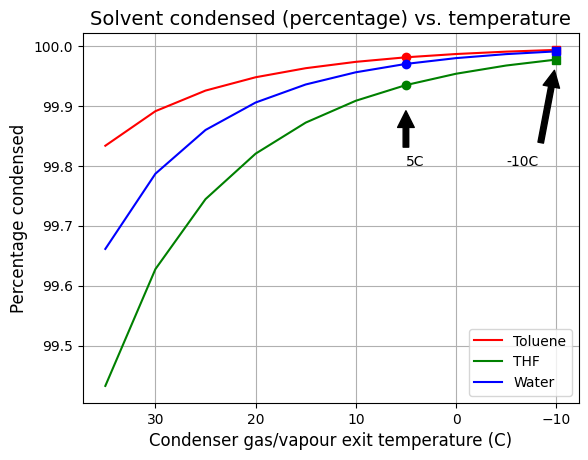

In [120]:
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
condenserTemperatureListCelcius = [t-273.2 for t in condenserTemperatureList]
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['toluene'],'-r')
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['THF'],'-g')
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['water'],'-b')

plt.xlabel('Condenser gas/vapour exit temperature (C)', fontsize=12)
plt.ylabel('Percentage condensed', fontsize=12)
plt.title('Solvent condensed (percentage) vs. temperature', fontsize=14)
plt.legend(['Toluene','THF','Water'])
plt.grid()
ax.annotate('5C', xy=(5, 99.9), xytext=(5, 99.8),
            arrowprops=dict(facecolor='black', shrink=0.1),)

reversedList = condenserTemperatureListCelcius[::-1]

from scipy.interpolate import CubicSpline
cs1 = CubicSpline(reversedList, percentCondensedDict['toluene'][::-1])
cs2 = CubicSpline(reversedList, percentCondensedDict['THF'][::-1])
cs3 = CubicSpline(reversedList, percentCondensedDict['water'][::-1])

T1 = 5 # Approach of 5C
plt.plot(T1, cs1(T1), 'or')
plt.plot(T1, cs2(T1), 'og')
plt.plot(T1, cs3(T1), 'ob')

T1 = -10 # Approach of 5C
plt.plot(T1, cs1(T1), 'sr')
plt.plot(T1, cs2(T1), 'sg')
plt.plot(T1, cs3(T1), 'sb')
ax.annotate('-10C', xy=(-10, 99.975), xytext=(-5, 99.8),
            arrowprops=dict(facecolor='black', shrink=0.1),)

plt.gca().invert_xaxis()

The composition of the vapour exiting the condenser is shown below, as function of exit temperature:

<Figure size 600x600 with 0 Axes>

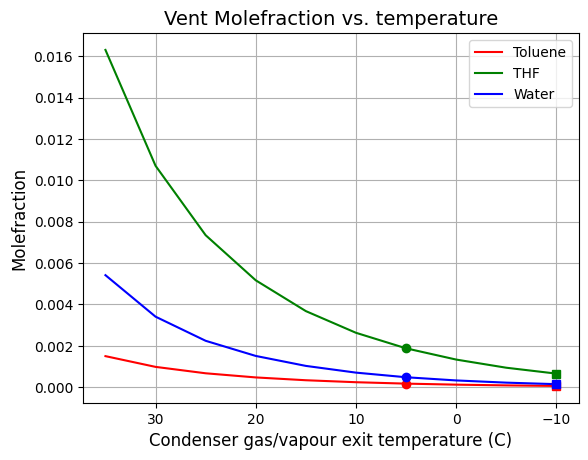

In [122]:
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
condenserTemperatureListCelcius = [t-273.2 for t in condenserTemperatureList]
plt.plot(condenserTemperatureListCelcius,ventMolefraction['toluene'],'-r')
plt.plot(condenserTemperatureListCelcius,ventMolefraction['THF'],'-g')
plt.plot(condenserTemperatureListCelcius,ventMolefraction['water'],'-b')

plt.xlabel('Condenser gas/vapour exit temperature (C)', fontsize=12)
plt.ylabel('Molefraction', fontsize=12)
plt.title('Vent Molefraction vs. temperature', fontsize=14)
plt.legend(['Toluene','THF','Water'])
plt.grid()

reversedList = condenserTemperatureListCelcius[::-1]

from scipy.interpolate import CubicSpline
cs1 = CubicSpline(reversedList, ventMolefraction['toluene'][::-1])
cs2 = CubicSpline(reversedList, ventMolefraction['THF'][::-1])
cs3 = CubicSpline(reversedList, ventMolefraction['water'][::-1])

T1 = 5 # Approach of 5C
plt.plot(T1, cs1(T1), 'or')
plt.plot(T1, cs2(T1), 'og')
plt.plot(T1, cs3(T1), 'ob')

T1 = -10 # Approach of 5C
plt.plot(T1, cs1(T1), 'sr')
plt.plot(T1, cs2(T1), 'sg')
plt.plot(T1, cs3(T1), 'sb')

plt.gca().invert_xaxis()

The composition of the overall liquid condensate (mixture of two phases) is shown below.

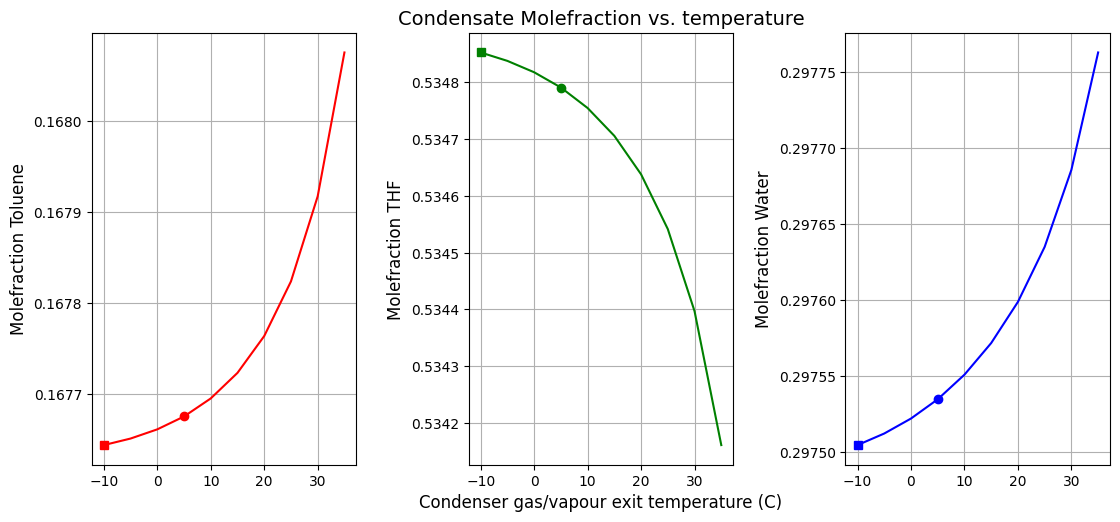

In [124]:
# plt.figure(figsize=(24,6))
fig, ax = plt.subplots(1,3, figsize=(12, 6))
fig.tight_layout(pad=5.0)

condenserTemperatureListCelcius = [t-273.2 for t in condenserTemperatureList]
plt.subplot
ax[0].plot(condenserTemperatureListCelcius,condensateMolefraction['toluene'],'-r')
ax[1].plot(condenserTemperatureListCelcius,condensateMolefraction['THF'],'-g')
ax[2].plot(condenserTemperatureListCelcius,condensateMolefraction['water'],'-b')

ax[1].set_xlabel('Condenser gas/vapour exit temperature (C)', fontsize=12) 
ax[0].set_ylabel('Molefraction Toluene', fontsize=12) 
ax[1].set_ylabel('Molefraction THF', fontsize=12) 
ax[2].set_ylabel('Molefraction Water', fontsize=12) 

ax[1].set_title('Condensate Molefraction vs. temperature', fontsize=14)

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

reversedList = condenserTemperatureListCelcius[::-1]

from scipy.interpolate import CubicSpline
cs1 = CubicSpline(reversedList, condensateMolefraction['toluene'][::-1])
cs2 = CubicSpline(reversedList, condensateMolefraction['THF'][::-1])
cs3 = CubicSpline(reversedList, condensateMolefraction['water'][::-1])

T1 = 5 # Approach of 5C
ax[0].plot(T1, cs1(T1), 'or')
ax[1].plot(T1, cs2(T1), 'og')
ax[2].plot(T1, cs3(T1), 'ob')

T1 = -10 # Approach of 5C
ax[0].plot(T1, cs1(T1), 'sr')
ax[1].plot(T1, cs2(T1), 'sg')
ax[2].plot(T1, cs3(T1), 'sb')

# ax[0].gca().invert_xaxis()

### 7.0 Case 2: Initial Evacuation from Atmospheric Pressure

The model here is a modified version of the above. THe liquid is initially at the feed temperature i.e. far from the bubble point.  To compoute the vapour composition, mass balances are computed on the initial amount of each liquid phase present, accounting for LL behaviour (as oppossed to VLL in Case 1).

#### 7.1 Model for vapour composition during evacuation

Equilibrium between the 2 liquid phases is given by (ref. Smith & van Ness p. 460):

$$
x_{toluene}^I \gamma_{toluene}^I  = x_{Dtoluene}^{II} \gamma_{toluene}^{II}
$$
$$
x_{THF}^I \gamma_{THF}^I  = x_{THF}^{II} \gamma_{THF}^{II}
$$
$$
x_{H2O}^I \gamma_{H2O}^I  = x_{H2O}^{II} \gamma_{H2O}^{II}
$$
where $I$ and $II$ represent the separate liquid phases in equilibrium. In each case, $\gamma$ is a function of composition and temperature.

A summation on molefraction in each phase is:
$$
x_{water}^I = 1- x_{toluene}^{I} - x_{THF}^{I}
$$
and
$$
x_{water}^{II} = 1- x_{toluene}^{II} - x_{THF}^{II}
$$
Vapour-liquid-liquid equilibrium (VLLE) is given by:

$$
y_{toluene} = \frac{x_{toluene}^{I} \gamma_{toluene}^{I}  p_{toluene}^S(T)}{P}
$$
$$
y_{THF} = \frac{x_{THF}^{II} \gamma_{THF}^{II}  p_{THF}^S(T)}{P}
$$
$$
y_{H2O} = \frac{x_{H2O}^{II} \gamma_{H2O}^{II}  p_{H2O}^S(T)}{P}
$$
where $p_{toluene}^S$, $p_{THF}^S$ and $p_{water}^S$ are pure-component vapour pressures, and $P$ is total pressure.  Note that $y_{toluene}$ and $y_{water)}$ are calculated from the phases in which the respective liquids are the main component, phases $I$ and $II$ respectively.  $y_{THF}$ is arbitrarily based on the composition in phase $II$.

A summation of vapour molefraction is:
$$
y_{inerts} = 1- y_{toluene}-y_{THF}- y_{H2O}
$$

Component molar balances are given by:
$$
M_{I}x_{toluene}^I + M_{II} x_{toluene}^{II} = M_{toluene} x_{toluene}^{TOT}
$$
for toluene, by
$$
M_{I}x_{THF}^I + M_{II}x_{THF}^{II} = M_{THF} x_{THF}^{TOT}
$$

for THF, and for H2O by:
$$
M_{I} x_{H2O}^I + M_{II} x_{H2O}^{II} = M_{H2O} x_{THF}^{TOT}
$$
where $M_{I}$, $M_{II}$ and $M_{TOT}$ are molar amounts of phases $I$, $II$ and the total molar quantity in the vessel.

The above represents 12 non-linear equations in 12 unknowns: $M_{I}$, $M_{II}$, $x_{toluene}^I$,  $x_{toluene}^{II}$, $x_{THF}^I$,  $x_{THF}^{II}$,  $x_{H2O}^I$,  $x_{H2O}^{II}$,  $y_{toluene}$,  $y_{THF}$,  $y_{H2O}$, $y_{INERTS}$.  
  
To estimate the flow of each component exiting the vessel during evacuation (a transient process), the molar flow of each component is related to the flow of inerts via:
$$
n_{TOL} = n_{INERTS} \frac{y_{TOL}}{y_{INERTS}} \qquad n_{THF} = n_{INERTS} \frac{y_{THF}}{y_{INERTS}} \qquad n_{H2O} = n_{INERTS} \frac{y_{H2O}}{y_{INERTS}}
$$

The flow of inerts $n_{INERTS}$ is given directly by the vacuum pump throughput if it can be assumed that all the solvent is removed in the condenser system upstream of the condenser.



#### 7.2 Numerical Solution (Case 2 initial evacuation)

The system of equations is solved numerically below in the "pyomo" framework, using the IPOPT solver.

In [126]:
# Pyomo model for solvent flow exiting vessel into condenser
from pyomo.environ import *
from tabulate import tabulate
from phasepy.actmodels import nrtl

P = initialPressure
print("Initial pressure:                    {:0.3f} barA".format(P ) )
# Initial vessel composition from above:
print("Molefraction toluene (liquid):       {:0.3f}".format( moleFractionInitial['toluene']) )
print("Molefraction THF (liquid):           {:0.3f}".format( moleFractionInitial['THF']) )
print("Molefraction water (liquid):         {:0.3f}".format( moleFractionInitial['water']) )


M1List=[]
M2List=[]
ventFlow={'toluene':[],'THF':[],'water':[],'inerts':[]}
ventMolefraction = {'toluene':[],'THF':[],'water':[],'inerts':[]  }

vesselTemperatureList=[20+273.2] 
for T in vesselTemperatureList:
    m = ConcreteModel()

    ## Define the objective to be a constant
    m.obj = Objective(expr=1)

    ## Define a set for components
    # ----------------------------
    m.COMPS = Set(initialize=["toluene","THF","water"])

    ################
    ## Parameters
    ################
    m.NTot = molesInitial['toluene'] + molesInitial['THF'] + molesInitial['water']
    m.z = Param(m.COMPS, initialize={"toluene":moleFractionInitial['toluene'], "THF":moleFractionInitial["THF"], "water":moleFractionInitial["water"]})

    m.P = Param(within=NonNegativeReals,initialize=P)
    m.T = Param(within=NonNegativeReals,mutable=True,initialize=T) #

    ################
    ## Variables
    ################
    m.xL1      = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.94, "THF":0.05, "water":0.01})  # variable, indexed by the set "COMPS"
    m.xL2      = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.01, "THF":0.05, "water":0.94})  # variable, indexed by the set "COMPS"
    m.y        = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.80, "THF":0.1, "water":0.10})  # variable, indexed by the set "COMPS"

    m.yInerts       = Var(within=NonNegativeReals, initialize=0.5) 
    m.M1            = Var(within=NonNegativeReals, initialize=molesInitial['toluene']) 
    m.M2            = Var(within=NonNegativeReals, initialize=molesInitial['water'])

    ##########################
    ## Constraint declarations
    ##########################
    # equation 1: overall mass balance
    # --------------------------------
    # m.overall_mass_balance = Constraint(expr=m.F_in == m.F_out + m.L1 + m.L2)

    # equations 2a / 2b: component mass balances
    # ------------------------------------------
    def eq_comp_mass_balance(m, c):
        ''' model: Pyomo model
            c: set for components
        '''
        return m.NTot*m.z[c] == m.xL1[c]*m.M1 + m.xL2[c]*m.M2 

    m.component_mass_balance= Constraint(m.COMPS, rule=eq_comp_mass_balance)

    # equation 4a/4b: Liquid-liquid equilibria
    # ----------------------------------------
    m.LLE_eq1 = Constraint( expr=   m.xL1["toluene"]*(  np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ) ) == 
                                    m.xL2["toluene"]*(  np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[0] )  ) )

    m.LLE_eq2 = Constraint( expr=   m.xL1["THF"]*(      np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ) ) == 
                                    m.xL2["THF"]*(      np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[1] )  ) )
    
    m.LLE_eq3 = Constraint( expr=   m.xL1["water"]*(    np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[2] ) ) == 
                                    m.xL2["water"]*(    np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )  ) )
    
        
    # equation 5a/5b/5c: molefraction summation constraints
    # ----------------------------------
    m.summation_M1 = Constraint( expr= m.xL1["toluene"] + m.xL1["THF"]  + m.xL1["water"] == 1 )
    m.summation_M2 = Constraint( expr= m.xL2["toluene"] + m.xL2["THF"]  + m.xL2["water"] == 1 )
    m.summation_V  = Constraint( expr= m.y["toluene"]   + m.y["THF"]    + m.y["water"] +m.yInerts == 1 )

    # equation 6a/6b: Vapour-liquid equilibria
    # ----------------------------------------
    m.VLE1  = Constraint( expr= m.y["toluene"]  == m.xL1["toluene"]*np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ) *toluene.psat(m.T.value) /m.P )   
    m.VLE2  = Constraint( expr= m.y["THF"]      == m.xL1["THF"]*np.exp(     nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ) *THF.psat(m.T.value) /m.P ) 
    m.VLE3  = Constraint( expr= m.y["water"]    == m.xL2["water"]*np.exp(   nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] ) *water.psat(m.T.value) /m.P )

    ## Print model
    # m.pprint()

    #############
    ## Solver
    #############
    solver = SolverFactory('ipopt')
    results = solver.solve(m, tee = False)

    gammaI  = { 'toluene':  np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'THF':      np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ),
                'water':    np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )} 
    
    gammaII = { 'toluene':  np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'THF':      np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ),
                'water':    np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )} 


    M1List.append(value(m.M1))   
    M2List.append(value(m.M2)) 

    ventMolefraction['toluene'].append( value(m.y["toluene"])   )
    ventMolefraction['THF'].append(     value(m.y["THF"])       )
    ventMolefraction['water'].append(   value(m.y["water"])     )
    ventMolefraction['inerts'].append(  value(m.yInerts)        )

MwAvgCondenserInlet = value(m.y["toluene"])*toluene.Mw + value(m.y["THF"])*THF.Mw +  value(m.y["water"])*water.Mw + value(m.yInerts)*Chemical('nitrogen').MW
condenserInletTemperature = value(m.T)

print("Vessel vent molefraction toluene:    {:.4f}".format( value(m.y["toluene"]) ))  
print("Vessel vent molefraction THF:        {:.4f}".format( value(m.y["THF"])  ))
print("Vessel vent molefraction water:      {:.4f}".format( value(m.y["water"])  ))
print("Vessel vent molefraction inerts:     {:.4f}".format( value(m.yInerts)  ))

print("Vessel/condenser inlet temperature:  {:.1f} C".format( condenserInletTemperature -273.2  ))

QVac = 190 # m3/hr
nInerts = 8.0 # kmol/hr
gasDensity =  MwAvgCondenserInlet /1000*value(m.P)*1E5 / (8.314*value(m.T))
inertsMolarDensity =  value(m.P)*1E5 / (8.314*(273.2+5))
vacPumpMolarThroughput = QVac*inertsMolarDensity
# print("Gas density                          {:.3f} kg/m3".format( gasDensity ))
# print("Inerts molar density                 {:.3f} mol/m3".format( inertsMolarDensity ))
print("Vacuum pump throughput               {:.1f} m3/hr".format( QVac ))
print("Vacuum pump throughput               {:.2f} kmol/hr".format( vacPumpMolarThroughput/1000 ))
print()


moleFlowCondenserInlet = {  'inerts':   nInerts,
                            'toluene':  nInerts*value(m.y["toluene"])/value(m.yInerts),
                            'THF':      nInerts*value(m.y["THF"])/value(m.yInerts),
                            'water':    nInerts*value(m.y["water"])/value(m.yInerts)
                            } 


moleFlowCondenserInletTotal = sum(moleFlowCondenserInlet.values())

moleFractionCondenserInlet = {  'toluene':  moleFlowCondenserInlet['toluene']/moleFlowCondenserInletTotal,
                                'THF':      moleFlowCondenserInlet["THF"]/moleFlowCondenserInletTotal,
                                'water':    moleFlowCondenserInlet["water"]/moleFlowCondenserInletTotal,
                                'inerts':   moleFlowCondenserInlet['inerts']/moleFlowCondenserInletTotal} 

MwAvgCondenserInlet = moleFractionCondenserInlet['toluene']*toluene.Mw + moleFractionCondenserInlet['THF']*THF.Mw + moleFractionCondenserInlet['water']*water.Mw + moleFractionCondenserInlet['inerts']*Chemical('nitrogen').MW
vesselVentMolarDensity = value(m.P)*1E5 / (8.314*(273.2+5))

print("Vessel vent molefraction toluene:    {:.4f}".format( moleFractionCondenserInlet['toluene'] ))  
print("Vessel vent molefraction THF:        {:.4f}".format( moleFractionCondenserInlet['THF']  ))
print("Vessel vent molefraction water:      {:.4f}".format( moleFractionCondenserInlet['water']  ))
print("Vessel vent molefraction inerts:     {:.4f}".format( moleFractionCondenserInlet['inerts']  ))
print("Vessel vent vapour molecular weight: {:.2f} gm/mol".format( MwAvgCondenserInlet   ))
print("Vessel vent molar density             {:.3f} mol/m3".format( vesselVentMolarDensity ))
print("Vessel/condenser inlet temperature:  {:.1f} C".format( condenserInletTemperature -273.2  ))
print()
print("Initial inerts molar flow ex. vessel  {:.2f} kmol/hr".format( moleFlowCondenserInlet['inerts'] ))
print("Initial toluene molar flow ex. vessel {:.2f} kmol/hr".format( moleFlowCondenserInlet['toluene'] ))
print("Initial THF molar flow ex. vessel     {:.2f} kmol/hr".format( moleFlowCondenserInlet['THF'] ))
print("Initial water molar flow ex. vessel   {:.2f} kmol/hr".format( moleFlowCondenserInlet['water'] ))
print("Total molar flow ex. vessel           {:.2f} kmol/hr".format( moleFlowCondenserInletTotal ))
print()
print("Total volumetric flow ex. vessel      {:.2f} m3/hr".format( moleFlowCondenserInletTotal/vesselVentMolarDensity*1000 ))
print() 
print("Initial inerts mass flow ex. vessel   {:.2f} kg/hr".format( moleFlowCondenserInlet['inerts']*Chemical('nitrogen').MW ))
print("Initial toluene mass flow ex. vessel  {:.2f} kg/hr".format( moleFlowCondenserInlet['toluene']*toluene.Mw ))
print("Initial THF mass flow ex. vessel      {:.2f} kg/hr".format( moleFlowCondenserInlet['THF']*THF.Mw ))
print("Initial water mass flow ex. vessel    {:.2f} kg/hr".format( moleFlowCondenserInlet['water']*water.Mw ))
       

Initial pressure:                    1.013 barA
Molefraction toluene (liquid):       0.485
Molefraction THF (liquid):           0.344
Molefraction water (liquid):         0.171
Vessel vent molefraction toluene:    0.0168
Vessel vent molefraction THF:        0.0418
Vessel vent molefraction water:      0.0230
Vessel vent molefraction inerts:     0.9184
Vessel/condenser inlet temperature:  20.0 C
Vacuum pump throughput               190.0 m3/hr
Vacuum pump throughput               8.32 kmol/hr

Vessel vent molefraction toluene:    0.0168
Vessel vent molefraction THF:        0.0418
Vessel vent molefraction water:      0.0230
Vessel vent molefraction inerts:     0.9184
Vessel vent vapour molecular weight: 31.24 gm/mol
Vessel vent molar density             43.797 mol/m3
Vessel/condenser inlet temperature:  20.0 C

Initial inerts molar flow ex. vessel  8.00 kmol/hr
Initial toluene molar flow ex. vessel 0.15 kmol/hr
Initial THF molar flow ex. vessel     0.36 kmol/hr
Initial water molar flow ex

Solve the condensation system for Case 2

In [139]:
# Pyomo model for partial condenser with two liquid phases
from pyomo.environ import *
from tabulate import tabulate
from phasepy.actmodels import nrtl



inlet_conditions = [
    ["Toluene", np.round(moleFlowCondenserInlet["toluene"],3),       toluene.Mw,                np.round(moleFractionCondenserInlet["toluene"],3), np.round(moleFractionCondenserInlet["toluene"]*P,3)],
    ["THF",     np.round(moleFlowCondenserInlet["THF"],3),           THF.Mw,                    np.round(moleFractionCondenserInlet["THF"],3),     np.round(moleFractionCondenserInlet["THF"]*P,3)],
    ["Water",   np.round(moleFlowCondenserInlet["water"],3),         water.Mw,                  np.round(moleFractionCondenserInlet["water"],3),  np.round(moleFractionCondenserInlet["water"]*P,3)],
    ["Inerts",  np.round(moleFlowCondenserInlet["inerts"],3),        "{:.2f}".format(Chemical('nitrogen').MW),               np.round(moleFractionCondenserInlet["inerts"],3),  np.round(moleFractionCondenserInlet["inerts"]*P,3)],
    ["Total:",  "{:.4f}".format(moleFlowCondenserInletTotal),        np.round(MwAvgCondenserInlet,2),  "{:.4f}".format(sum(moleFractionCondenserInlet.values())),  "{:.4f}".format(sum(moleFractionCondenserInlet.values())*P)]
]

print("Inlet vapour conditions at {:0.2f} C: ".format(condenserInletTemperature -273.2 ) )
table = tabulate(inlet_conditions, headers=["Component","Inlet flow (mol/s)", "Molecular Weight", \
                                  "Mole fraction","Partial Pressure (bar)",],\
                                    tablefmt='html',disable_numparse=True)

from IPython.display import HTML, display
display(HTML(table))

L1List=[]
L2List=[]
ventFlow={'toluene':[],'THF':[],'water':[],'inerts':[]}
percentCondensedDict ={'toluene':[],'THF':[],'water':[],'inerts':[]}
condensateMolefraction = {'toluene':[],'THF':[],'water':[] }
ventMolefraction = {'toluene':[],'THF':[],'water':[],'inerts':[]  }

condenserTemperatureList=[10+273.2, 5+273.2, 0+273.2, -5+273.2, -10+273.2]
for T in condenserTemperatureList:
    m = ConcreteModel()

    ## Define the objective to be a constant
    m.obj = Objective(expr=1)

    ## Define a set for components
    # ----------------------------
    m.COMPS = Set(initialize=["toluene","THF","water","inerts"])

    ################
    ## Parameters
    ################
    m.F_in = Param(within=NonNegativeReals,initialize=moleFlowCondenserInletTotal)
    m.z = Param(m.COMPS, initialize={"toluene":moleFractionCondenserInlet["toluene"], "THF":moleFractionCondenserInlet["THF"], "water":moleFractionCondenserInlet["water"], "inerts":moleFractionCondenserInlet["inerts"]})
    m.P = Param(within=NonNegativeReals,initialize=P)
    m.T = Param(within=NonNegativeReals,mutable=True,initialize=T) #

    ################
    ## Variables
    ################
    m.xL1      = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.94, "THF":0.05, "water":0.01, "inerts": 0})  # variable, indexed by the set "COMPS"
    m.xL2      = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":0.01, "THF":0.05, "water":0.94, "inerts": 0})  # variable, indexed by the set "COMPS"
    m.y        = Var(m.COMPS, bounds=(0, 1.0), initialize={"toluene":moleFractionCondenserInlet["toluene"], "THF":moleFractionCondenserInlet["THF"], "water":moleFractionCondenserInlet["water"], "inerts":moleFractionCondenserInlet["inerts"]})  # variable, indexed by the set "COMPS"

    # m.yInerts       = Var(within=NonNegativeReals, initialize=moleFractionCondenserInlet["inerts"]) 
    m.L1            = Var(within=NonNegativeReals, initialize=moleFlowCondenserInlet["toluene"]) 
    m.L2            = Var(within=NonNegativeReals, initialize=moleFlowCondenserInlet["water"])
    m.F_out         = Var(within=NonNegativeReals, initialize=moleFlowCondenserInletTotal)

    ##########################
    ## Constraint declarations
    ##########################
    # equation 1: overall mass balance
    # --------------------------------
    m.overall_mass_balance = Constraint(expr=m.F_in - m.F_out - m.L1 - m.L2 == 0)

    # equations 2a / 2b: component mass balances
    # ------------------------------------------
    def eq_comp_mass_balance(m, c):
        ''' model: Pyomo model
            c: set for components
        '''
        return m.F_in*m.z[c] == m.xL1[c]*m.L1 + m.xL2[c]*m.L2 + m.F_out*m.y[c]

    m.component_mass_balance= Constraint(m.COMPS, rule=eq_comp_mass_balance)

    # equation 4a/4b: Liquid-liquid equilibria
    # ----------------------------------------
    m.LLE_eq1 = Constraint( expr=   m.xL1["toluene"]*(  np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ) ) == 
                                    m.xL2["toluene"]*(  np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[0] )  ) )

    m.LLE_eq2 = Constraint( expr=   m.xL1["THF"]*(      np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ) ) == 
                                    m.xL2["THF"]*(      np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[1] )  ) )
    
    m.LLE_eq3 = Constraint( expr=   m.xL1["water"]*(    np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[2] ) ) == 
                                    m.xL2["water"]*(    np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )  ) )
    
        
    # equation 5a/5b/5c: molefraction summation constraints
    # ----------------------------------
    m.summation_L1 = Constraint( expr= m.xL1["toluene"] + m.xL1["THF"]  + m.xL1["water"]  == 1 )
    m.summation_L2 = Constraint( expr= m.xL2["toluene"] + m.xL2["THF"]  + m.xL2["water"]  == 1 )
    m.summation_V  = Constraint( expr= m.y["toluene"]   + m.y["THF"]    + m.y["water"] + m.y["inerts"] == 1 )

    # equation 6a/6b: Vapour-liquid equilibria
    # ----------------------------------------
    m.VLE1  = Constraint( expr= m.y["toluene"]  == m.xL1["toluene"]*np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ) *toluene.psat(m.T.value) /m.P )   
    m.VLE2  = Constraint( expr= m.y["THF"]      == m.xL1["THF"]*np.exp(     nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ) *THF.psat(m.T.value) /m.P ) 
    m.VLE3  = Constraint( expr= m.y["water"]    == m.xL2["water"]*np.exp(   nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] ) *water.psat(m.T.value) /m.P )

    ## Print model
    # m.pprint()

    #############
    ## Solver
    #############
    solver = SolverFactory('ipopt')
    results = solver.solve(m, tee = False)

    gammaI  = { 'toluene':  np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'THF':      np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ),
                'water':    np.exp( nrtl([m.xL1["toluene"].value, m.xL1["THF"].value, m.xL1["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )} 
    
    gammaII = { 'toluene':  np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'THF':      np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[1] ),
                'water':    np.exp( nrtl([m.xL2["toluene"].value, m.xL2["THF"].value, m.xL2["water"].value],m.T.value,alpha, Aij0, Aij1)[2] )} 

    percentCondensed = {'toluene':   100*(1-value(m.F_out)*value(m.y["toluene"])/moleFlowCondenserInlet["toluene"]),
                        'THF':       100*(1-value(m.F_out)*value(m.y["THF"])/moleFlowCondenserInlet["THF"]),
                        'water':     100*(1-value(m.F_out)*value(m.y["water"])/moleFlowCondenserInlet["water"]),
                        'inerts':    100*(1-value(m.F_out)*value(m.y["inerts"])/moleFlowCondenserInlet["inerts"]),
                        'total':     100*(1-value(m.F_out)/moleFlowCondenserInletTotal)}

    L1List.append(value(m.L1))   
    L2List.append(value(m.L2)) 
    ventFlow['toluene'].append(value(m.F_out)*value(m.y["toluene"]))
    ventFlow['THF'].append(value(m.F_out)*value(m.y["toluene"]))
    ventFlow['water'].append(value(m.F_out)*value(m.y["water"]))
    ventFlow['inerts'].append(value(m.F_out)*value(m.y["inerts"]))

    ventMolefraction['toluene'].append(value(m.F_out)*value(m.y["toluene"]))
    ventMolefraction['THF'].append(value(m.F_out)*value(m.y["THF"]))
    ventMolefraction['water'].append(value(m.F_out)*value(m.y["water"]))
    ventMolefraction['inerts'].append(value(m.F_out)*value(m.y["inerts"]))

    percentCondensedDict['toluene'].append( percentCondensed['toluene'] )
    percentCondensedDict['THF'].append( percentCondensed['THF'] )
    percentCondensedDict['water'].append( percentCondensed['water'] )

    condensateMolefraction['toluene'].append( (value(m.L1)*value(m.xL1["toluene"]) + value(m.L2)*value(m.xL2["toluene"]))/( value(m.L1)+value(m.L2) ) )
    condensateMolefraction['THF'].append( (value(m.L1)*value(m.xL1["THF"]) + value(m.L2)*value(m.xL2["THF"]))/( value(m.L1)+value(m.L2) ) )
    condensateMolefraction['water'].append( (value(m.L1)*value(m.xL1["water"]) + value(m.L2)*value(m.xL2["water"]))/( value(m.L1)+value(m.L2) ) )
    
xOut = {    'toluene':  (value(m.L1)*value(m.xL1["toluene"])+value(m.L2)*value(m.xL2["toluene"]))/(value(m.L1)+value(m.L2)),
                'THF':      (value(m.L1)*value(m.xL1["THF"])+value(m.L2)*value(m.xL2["THF"]))/(value(m.L1)+value(m.L2)),
                'water':    (value(m.L1)*value(m.xL1["water"])+value(m.L2)*value(m.xL2["water"]))/(value(m.L1)+value(m.L2)),
                'inerts':   (value(m.L1)*value(m.xL1["inerts"])+value(m.L2)*value(m.xL2["inerts"]))/(value(m.L1)+value(m.L2))} 

print("Overall Mass Balance at gas/vapour exit temperature of {:0.1f} C: ".format(T-273.2) )
print()
from IPython.display import HTML, display
sumyOut = value(m.y["toluene"])+value(m.y["THF"])+value(m.y["water"])+value(m.y["inerts"])
condenser_result_table = [
    ["Toluene:",    moleFlowCondenserInlet["toluene"],   moleFractionCondenserInlet["toluene"],   "{:.4f}".format(value(m.L1)*value(m.xL1["toluene"])),   "{:.4f}".format(value(m.xL1["toluene"])),   "{:.4f}".format(value(m.L2)*value(m.xL2["toluene"])),   "{:.4f}".format(value(m.xL2["toluene"])),  "{:.4f}".format(xOut["toluene"]),   "{:.6e}".format(value(m.F_out)*value(m.y["toluene"])),  "{:.6f}".format(value(m.y["toluene"])), "{:3.4f}".format(percentCondensed['toluene'])],
    ["THF:",        moleFlowCondenserInlet["THF"],       moleFractionCondenserInlet["THF"],       "{:.4f}".format(value(m.L1)*value(m.xL1["THF"])),       "{:.4f}".format(value(m.xL1["THF"])),       "{:.4f}".format(value(m.L2)*value(m.xL2["THF"])),       "{:.4f}".format(value(m.xL2["THF"])),      "{:.4f}".format(xOut["THF"]),       "{:.6e}".format(value(m.F_out)*value(m.y["THF"])),      "{:.6f}".format(value(m.y["THF"])),     "{:3.4f}".format(percentCondensed['THF'])],
    ["Water:",      moleFlowCondenserInlet["water"],     moleFractionCondenserInlet["water"],     "{:.4f}".format(value(m.L1)*value(m.xL1["water"])),     "{:.4f}".format(value(m.xL1["water"])),     "{:.4f}".format(value(m.L2)*value(m.xL2["water"])),     "{:.4f}".format(value(m.xL2["water"])),    "{:.4f}".format(xOut["water"]),     "{:.6e}".format(value(m.F_out)*value(m.y["water"])),    "{:.6f}".format(value(m.y["water"])),   "{:.4f}".format(percentCondensed['water'])],
    ["Inerts:",     moleFlowCondenserInlet["inerts"],    moleFractionCondenserInlet["inerts"],    "{:.4f}".format(value(m.L1)*value(m.xL1["inerts"])),    "{:.4f}".format(value(m.xL1["inerts"])),    "{:.4f}".format(value(m.L2)*value(m.xL2["inerts"])),    "{:.4f}".format(value(m.xL2["inerts"])),   "{:.4f}".format(xOut["inerts"]),    "{:.6f}".format(value(m.F_out)*value(m.y["inerts"])),   "{:.6f}".format(value(m.y["inerts"])),  "{:.4e}".format(percentCondensed['inerts'])],
    ["Totals:",     sum(moleFlowCondenserInlet.values()), sum(moleFractionCondenserInlet.values()),        "{:.4f}".format(value(m.L1)),                    "{:.4f}".format(value(m.xL1["toluene"])+value(m.xL1["THF"])+value(m.xL1["water"])),   "{:.4f}".format(value(m.L2)), "{:.4f}".format(value(m.xL2["toluene"])+value(m.xL2["THF"])+value(m.xL2["water"])) ,   "{:.4f}".format(sum(xOut.values())),  "{:.6f}".format(value(m.F_out)),    sumyOut, "{:.4f}".format(percentCondensed['total'])]
    ]
table = tabulate(condenser_result_table , headers=["Component","Inlet flowrate (mol/s)","Inlet Molefraction", "Phase 1 flowrate (mol/s)", 
                                                "Phase 1 molefraction", "Phase 2 flowrate (mol/s)", "Phase 2 molefraction", "Liquid molefraction (overall)", "Vent flowrate (mol/s)", "Vent molefraction", "% Condensed"],\
                                    tablefmt='html',floatfmt=".3f")
display(HTML(table))

phases_result_table = [
    ["Inlet",   "{:.4f}".format(sum(moleFlowCondenserInlet.values())), "{:.4f}".format(moleFractionCondenserInlet["toluene"]), "{:.4f}".format(moleFractionCondenserInlet["THF"]), "{:.4f}".format(moleFractionCondenserInlet["water"]),"{:.4f}".format(moleFractionCondenserInlet["inerts"]), "N/A", "N/A", "N/A"],
    ["Vent",    "{:.4f}".format(value(m.F_out)), "{:.4f}".format(value(m.y["toluene"])), "{:.4f}".format(value(m.y["THF"])), "{:.4f}".format(value(m.y["water"])),"{:.4f}".format(value(m.y["inerts"])), "N/A", "N/A", "N/A"],
    ["Organic", "{:.4f}".format(value(m.L1)), "{:.4f}".format(value(m.xL1["toluene"])), "{:.4f}".format(value(m.xL1["THF"])), "{:.4f}".format(value(m.xL1["water"])),"N/A", "{:.2f}".format(gammaI["toluene"]), "{:.2f}".format(gammaI["THF"]),"{:.2f}".format(gammaI["water"])],
    ["Aqueous", "{:.4f}".format(value(m.L2)), "{:.4f}".format(value(m.xL2["toluene"])), "{:.4f}".format(value(m.xL2["THF"])), "{:.4f}".format(value(m.xL2["water"])),"N/A", "{:.2f}".format(gammaII["toluene"]), "{:.2f}".format(gammaII["THF"]), "{:.2f}".format(gammaII["water"])],
    ["Total Liquid","{:.4f}".format(value(m.L1)+value(m.L2)), "{:.4f}".format(xOut["toluene"]), "{:.4f}".format(xOut["THF"]), "{:.4f}".format(xOut["water"]),"N/A","N/A","N/A", "N/A"]
]
table = tabulate(phases_result_table , headers=["Phase","Phase flowrate (mol/s)", "Toluene Molefraction", "THF Molefraction", "Water Molefraction", "Inerts Molefraction", "Activity Coefficient (Toluene)", "Activity Coefficient (THF)", "Activity Coefficient (Water)"],\
                                    tablefmt='html')
display(HTML(table))

# print("Balance on toluene:", moleFlowCondenserInlet["toluene"]- value(m.L1)*value(m.xL1["toluene"]) - value(m.L2)*value(m.xL2["toluene"]) - value(m.F_out)*value(m.y["toluene"]))
# print("Balance on THF:", moleFlowCondenserInlet["THF"]- value(m.L1)*value(m.xL1["THF"]) - value(m.L2)*value(m.xL2["THF"]) - value(m.F_out)*value(m.y["THF"]))
# print("Balance on water:", moleFlowCondenserInlet["water"]- value(m.L1)*value(m.xL1["water"]) - value(m.L2)*value(m.xL2["water"]) - value(m.F_out)*value(m.y["water"]))
# print("Balance on inerts:", moleFlowCondenserInlet["inerts"] - value(m.F_out)*value(m.y["inerts"]))
# print("Balance on overall flow", value(m.F_out) - value(m.F_in) - value(m.L1) - value(m.L2))
print()

Inlet vapour conditions at 20.00 C: 


Component,Inlet flow (mol/s),Molecular Weight,Mole fraction,Partial Pressure (bar)
Toluene,0.146,92.14,0.017,0.017
THF,0.364,84.93,0.042,0.042
Water,0.2,18.02,0.023,0.023
Inerts,8.0,28.01,0.918,0.93
Total:,8.7110,31.24,1.0000,1.0130


Overall Mass Balance at gas/vapour exit temperature of -10.0 C: 



Component,Inlet flowrate (mol/s),Inlet Molefraction,Phase 1 flowrate (mol/s),Phase 1 molefraction,Phase 2 flowrate (mol/s),Phase 2 molefraction,Liquid molefraction (overall),Vent flowrate (mol/s),Vent molefraction,% Condensed
Toluene:,0.146,0.017,0.134,0.332,0.000,0.001,0.227,0.012,0.001,91.687
THF:,0.364,0.042,0.270,0.668,0.008,0.043,0.471,0.086,0.011,76.381
Water:,0.200,0.023,0.000,0.000,0.178,0.957,0.302,0.022,0.003,89.151
Inerts:,8.000,0.918,0.000,0.000,0.000,0.000,0.000,8.000,0.985,0.000
Totals:,8.711,1.000,0.405,1.000,0.187,1.000,1.000,8.120,1.000,6.785


Phase,Phase flowrate (mol/s),Toluene Molefraction,THF Molefraction,Water Molefraction,Inerts Molefraction,Activity Coefficient (Toluene),Activity Coefficient (THF),Activity Coefficient (Water)
Inlet,8.711,0.0168,0.0418,0.023,0.9184,N/A,N/A,N/A
Vent,8.1199,0.0015,0.0106,0.0027,0.9852,N/A,N/A,N/A
Organic,0.4045,0.3317,0.6682,0.0001,N/A,0.75,0.96,51.49
Aqueous,0.1866,0.0006,0.0429,0.9566,N/A,1171.32,10.08,1.01
Total Liquid,0.5911,0.2272,0.4708,0.302,N/A,N/A,N/A,N/A


### 7.3 Condenser performance vs. gas/vapour exit temperature (Case 2)

Dots on figure below represent a 7C gas/vapour temperature, corresponding to a 5C approach to 2C glycol inlet temperature.

Squares represent a -12C gas/vapour temperature, i.e. a 5C approach to -17C glycol inlet.

<Figure size 600x600 with 0 Axes>

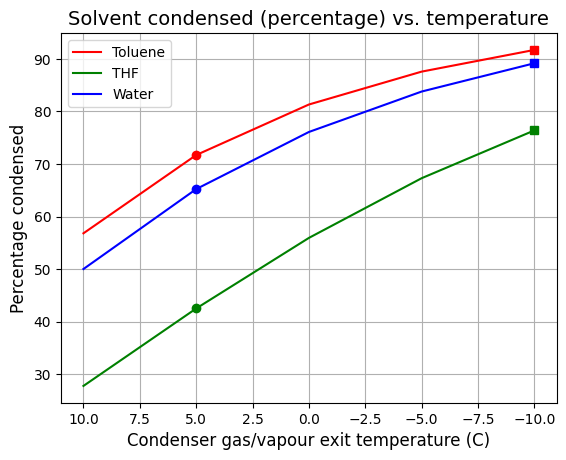

In [138]:
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
condenserTemperatureListCelcius = [t-273.2 for t in condenserTemperatureList]
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['toluene'],'-r')
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['THF'],'-g')
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['water'],'-b')

plt.xlabel('Condenser gas/vapour exit temperature (C)', fontsize=12)
plt.ylabel('Percentage condensed', fontsize=12)
plt.title('Solvent condensed (percentage) vs. temperature', fontsize=14)
plt.legend(['Toluene','THF','Water'])
plt.grid()
ax.annotate('5C', xy=(5, 99.9), xytext=(5, 99.8),
            arrowprops=dict(facecolor='black', shrink=0.1),)

reversedList = condenserTemperatureListCelcius[::-1]

from scipy.interpolate import CubicSpline
cs1 = CubicSpline(reversedList, percentCondensedDict['toluene'][::-1])
cs2 = CubicSpline(reversedList, percentCondensedDict['THF'][::-1])
cs3 = CubicSpline(reversedList, percentCondensedDict['water'][::-1])

T1 = 5 # Approach of 5C
plt.plot(T1, cs1(T1), 'or')
plt.plot(T1, cs2(T1), 'og')
plt.plot(T1, cs3(T1), 'ob')

T1 = -10 # Approach of 5C
plt.plot(T1, cs1(T1), 'sr')
plt.plot(T1, cs2(T1), 'sg')
plt.plot(T1, cs3(T1), 'sb')
ax.annotate('-10C', xy=(-10, 99.975), xytext=(-5, 99.8),
            arrowprops=dict(facecolor='black', shrink=0.1),)

plt.gca().invert_xaxis()

The composition of the vapour exiting the condenser is shown below, as function of exit temperature. Lower temperatures correspond to more condensation, therefore reduced vent molefraction.

<Figure size 600x600 with 0 Axes>

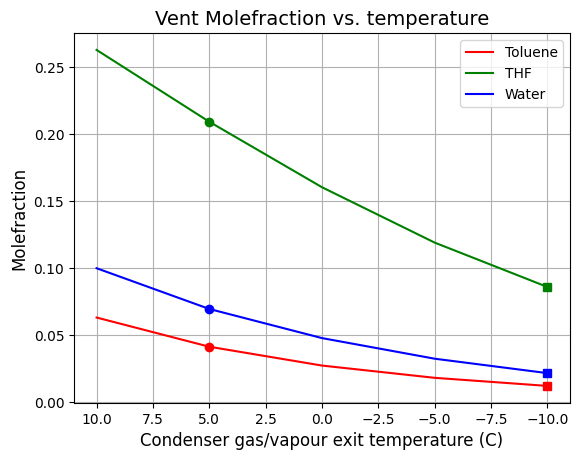

In [137]:
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
condenserTemperatureListCelcius = [t-273.2 for t in condenserTemperatureList]
plt.plot(condenserTemperatureListCelcius,ventMolefraction['toluene'],'-r')
plt.plot(condenserTemperatureListCelcius,ventMolefraction['THF'],'-g')
plt.plot(condenserTemperatureListCelcius,ventMolefraction['water'],'-b')

plt.xlabel('Condenser gas/vapour exit temperature (C)', fontsize=12)
plt.ylabel('Molefraction', fontsize=12)
plt.title('Vent Molefraction vs. temperature', fontsize=14)
plt.legend(['Toluene','THF','Water'])
plt.grid()

reversedList = condenserTemperatureListCelcius[::-1]

from scipy.interpolate import CubicSpline
cs1 = CubicSpline(reversedList, ventMolefraction['toluene'][::-1])
cs2 = CubicSpline(reversedList, ventMolefraction['THF'][::-1])
cs3 = CubicSpline(reversedList, ventMolefraction['water'][::-1])

T1 = 5 # Approach of 5C
plt.plot(T1, cs1(T1), 'or')
plt.plot(T1, cs2(T1), 'og')
plt.plot(T1, cs3(T1), 'ob')

T1 = -10 # Approach of 5C
plt.plot(T1, cs1(T1), 'sr')
plt.plot(T1, cs2(T1), 'sg')
plt.plot(T1, cs3(T1), 'sb')

plt.gca().invert_xaxis()